In [180]:
import os
import pandas as pd
pd.options.display.max_rows = 10
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
import lightgbm as lightgbm
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import RegressorChain
import seaborn as sns

cantonKeys = ['AG','AI','AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG','ZH']


data = pd.read_csv("completedata.csv")

for col in data.columns:
    if data[col].isna().sum() != 0:
        print(col+" (#NaN/#NotNaN): (" + str(data[col].isna().sum())+"/"+str(data[col].notna().sum())+")")
        #display(filled[[col]])

numberOfInputWeeks = 3
numberOfOutputWeeks = 4
#display([col for col in data.columns])

train_features = data[data['category']=='train'].iloc[:,0:-22].drop(['lastInputDay'], axis=1)
train_labels = data[data['category']=='train'].iloc[:,-22:-2]
#display(len([col for col in train_features.columns]))
#display([col for col in train_labels.columns])
validation1_features = data[data['category']=='validation 1'].iloc[:,0:-22].drop(['lastInputDay'], axis=1)
validation1_labels = data[data['category']=='validation 1'].iloc[:,-22:-2]
validation2_features = data[data['category']=='validation 2'].iloc[:,0:-22].drop(['lastInputDay'], axis=1)
validation2_labels = data[data['category']=='validation 2'].iloc[:,-22:-2]

'''
cId = 'AI'
train_features = data[(data['category']=='train')].iloc[:,0:-26]
train_labels = data[(data['category']=='train')].iloc[:,-26:-2]
validation1_features = data[(data['category']=='validation 1') & (data['cantonId']==cId)].iloc[:,0:-26]
validation1_labels = data[(data['category']=='validation 1') & (data['cantonId']==cId)].iloc[:,-26:-2]
validation2_features = data[(data['category']=='validation 2') & (data['cantonId']==cId)].iloc[:,0:-26]
validation2_labels = data[(data['category']=='validation 2') & (data['cantonId']==cId)].iloc[:,-26:-2]
'''


outputCategories = ['hosp_inz_entries_7dayAverage',
                    'death_inz_entries_7dayAverage',
                    'testPositvity_7dayAverage',
                    'workplaces_percent_change_from_baseline_7dayAverage',
                    'transit_stations_percent_change_from_baseline_7dayAverage'
                   ]

'''
inputDict = {'hosp_inz_entries_7dayAverage':['Cases inz_entries 60+_weekMean_0',
                                          'Cases inz_entries 60+_weekMean_1',
                                          'Cases inz_entries 60+_weekMean_2',
                                          'hosp_inz_entries_slope_0',
                                          'hosp_inz_entries_range_0',
                                          'hosp_inz_entries_median_0',
                                          'hosp_inz_entries_weekMean_0',
                                          'hosp_inz_entries_slope_1',
                                          'hosp_inz_entries_range_1',
                                          'hosp_inz_entries_median_1',
                                          'hosp_inz_entries_weekMean_1',
                                          'hosp_inz_entries_slope_2',
                                          'hosp_inz_entries_range_2',
                                          'hosp_inz_entries_median_2',
                                          'hosp_inz_entries_weekMean_2',
                                         'VaccDosesAdministered per100PersonsTotal_weekMean_0',
                                         'FullyVaccPersons per100PersonsTotal_weekMean_0',
                                         'anteil_pos_weekMean_0',
                                        'VaccDosesAdministered per100PersonsTotal_weekMean_1',
                                         'FullyVaccPersons per100PersonsTotal_weekMean_1',
                                         'anteil_pos_weekMean_1',
                                        'VaccDosesAdministered per100PersonsTotal_weekMean_2',
                                         'FullyVaccPersons per100PersonsTotal_weekMean_2',
                                         'anteil_pos_weekMean_2',
                                          'percentage 65 years or over',],
             'death_inz_entries_7dayAverage':['Hosp inz_entries 60+_weekMean_0',
                                           'Hosp inz_entries 60+_weekMean_1',
                                           'Hosp inz_entries 60+_weekMean_2',
                                           'death_inz_entries_slope_0',
                                            'death_inz_entries_range_0',
                                            'death_inz_entries_median_0',
                                           'death_inz_entries_weekMean_0',
                                           'death_inz_entries_slope_1',
                                            'death_inz_entries_range_1',
                                            'death_inz_entries_median_1',
                                           'death_inz_entries_weekMean_1',
                                           'death_inz_entries_slope_2',
                                            'death_inz_entries_range_2',
                                             'death_inz_entries_median_2',
                                           'death_inz_entries_weekMean_2',
                                         'ICU_Covid19Patients_inz_weekMean_2',
                                         'ICU_Capacity_inz_weekMean_2',
                                         'Total_Covid19Patients_inz_weekMean_2',
                                         'ICU_FreeCapacity_inz_weekMean_2',
                                          'VaccDosesAdministered per100PersonsTotal_weekMean_0',
                                         'FullyVaccPersons per100PersonsTotal_weekMean_0',
                                         'anteil_pos_weekMean_0',
                                        'VaccDosesAdministered per100PersonsTotal_weekMean_1',
                                         'FullyVaccPersons per100PersonsTotal_weekMean_1',
                                         'anteil_pos_weekMean_1',
                                        'VaccDosesAdministered per100PersonsTotal_weekMean_2',
                                         'FullyVaccPersons per100PersonsTotal_weekMean_2',
                                         'anteil_pos_weekMean_2',
                                          'percentage 65 years or over',
                                           'DoctorsPer100Kinhabitants',],
             'testPositvity_7dayAverage':['testPositvity_slope_0',
                                        'testPositvity_range_0',
                                        'testPositvity_median_0',
                                        'test_inz_entries_weekMean_0',
                                      'testPositvity_slope_1',
                                        'testPositvity_range_1',
                                        'testPositvity_median_1',
                                        'test_inz_entries_weekMean_1',
                                      'testPositvity_slope_2',
                                        'testPositvity_range_2',
                                        'testPositvity_median_2',
                                        'test_inz_entries_weekMean_2',
                                       'kofStrigency_weekMean_0',
                                       'kofStrigency_weekMean_1',
                                       'kofStrigency_weekMean_2',
                                       'VaccDosesAdministered per100PersonsTotal_weekMean_0',
                                         'FullyVaccPersons per100PersonsTotal_weekMean_0',
                                         'anteil_pos_weekMean_0',
                                        'VaccDosesAdministered per100PersonsTotal_weekMean_1',
                                         'FullyVaccPersons per100PersonsTotal_weekMean_1',
                                         'anteil_pos_weekMean_1',
                                        'VaccDosesAdministered per100PersonsTotal_weekMean_2',
                                         'FullyVaccPersons per100PersonsTotal_weekMean_2',
                                         'anteil_pos_weekMean_2',
                                       '2PersonHouseholds_perc',
                                         '3PersonHouseholds_perc',
                                         '4PersonHouseholds_perc',
                                         '5PersonHouseholds_perc',
                                         '6+PersonHouseholds_perc',
                                         'averageHousehold',
                                         'carsPer1000inhabitants',
                                         'publicTransportationPercent',
                                         'privateMotorisedTransportPercent',
                                        'homeownershipPercent',
                                       'livingSpaceInm2',
                                       'residentsPerKm2',
                                         'residentsPerKm2SettlementArea', 
                                      ],
             'workplaces_percent_change_from_baseline_7dayAverage':[
                                         'workplaces_percent_change_from_baseline_slope_0',
                                         'workplaces_percent_change_from_baseline_range_0',
                                         'workplaces_percent_change_from_baseline_median_0',
                                         'workplaces_percent_change_from_baseline_slope_1',
                                         'workplaces_percent_change_from_baseline_range_1',
                                         'workplaces_percent_change_from_baseline_median_1',
                                         'workplaces_percent_change_from_baseline_slope_2',
                                         'workplaces_percent_change_from_baseline_range_2',
                                         'workplaces_percent_change_from_baseline_median_2',
                                         'workplaces_percent_change_from_baseline_weekMean_0',
                                         'workplaces_percent_change_from_baseline_weekMean_1',
                                         'workplaces_percent_change_from_baseline_weekMean_2',
                                         'kofStrigency_weekMean_0',
                                         'intervistaMob_weekMean_0',
                                         'kofStrigency_weekMean_1',
                                         'intervistaMob_weekMean_1',
                                         'kofStrigency_weekMean_2',
                                         'intervistaMob_weekMean_2',
                                         'Homeworking_weekMean_2',
                                         'isHoliday_weekMean_2',
                                         'percentage 65 years or over',
                                          ],
             'transit_stations_percent_change_from_baseline_7dayAverage':[ 
                                         'transit_stations_percent_change_from_baseline_slope_0',
                                         'transit_stations_percent_change_from_baseline_range_0',
                                         'transit_stations_percent_change_from_baseline_median_0',
                                         'transit_stations_percent_change_from_baseline_slope_1',
                                         'transit_stations_percent_change_from_baseline_range_1',
                                         'transit_stations_percent_change_from_baseline_median_1',
                                         'transit_stations_percent_change_from_baseline_slope_2',
                                         'transit_stations_percent_change_from_baseline_range_2',
                                         'transit_stations_percent_change_from_baseline_median_2',
                                         'transit_stations_percent_change_from_baseline_weekMean_0',
                                         'transit_stations_percent_change_from_baseline_weekMean_1',
                                         'transit_stations_percent_change_from_baseline_weekMean_2',
                                         'kofStrigency_weekMean_0',
                                         'intervistaMob_weekMean_0',
                                         'kofStrigency_weekMean_1',
                                         'intervistaMob_weekMean_1',
                                         'kofStrigency_weekMean_2',
                                         'intervistaMob_weekMean_2',
                                         'Borders_weekMean_2',
                                         'Events_weekMean_2',
                                         'Gatherings/private events_weekMean_2',
                                         'Demonstrations_weekMean_2',
                                         'Primary (includes kindergarten) and lower secondary school_weekMean_2',
                                         'Upper secondary school, vocational schools and higher education_weekMean_2',
                                         'Universities and other educational establishments_weekMean_2',
                                         'Mountain railways_weekMean_2',
                                         'Homeworking_weekMean_2',
                                         'Restaurants_weekMean_2',
                                         'Discos/Nightclubs_weekMean_2',
                                         'Shops/Markets_weekMean_2',
                                         'Penalties_weekMean_2',
                                         'Cultural, entertainment and recreational facilities_weekMean_2',
                                         'Sport/Wellness facilities_weekMean_2',
                                         'Sport activities_weekMean_2',
                                         'Religious services_weekMean_2',
                                         'Singing allowed_weekMean_2',
                                         'isHoliday_weekMean_2',
                                         'temp_min_weekMean_2',
                                         'temp_max_weekMean_2',
                                         'clouds_weekMean_2',
                                         'precipitation_weekMean_2',
                                         'maskMandatories_weekMean_2',
                                         'urbanPopulationPercent',
                                         'carsPer1000inhabitants',
                                         'publicTransportationPercent',
                                         'privateMotorisedTransportPercent',
                                        'homeownershipPercent',
                                         'livingSpaceInm2',
                                          'residentsPerKm2',
                                         'residentsPerKm2SettlementArea' ]
            }
'''
inputDict = {'hosp_inz_entries_7dayAverage': train_features.columns,
             'death_inz_entries_7dayAverage':train_features.columns,
             'testPositvity_7dayAverage': train_features.columns,
             'workplaces_percent_change_from_baseline_7dayAverage': train_features.columns,
             'transit_stations_percent_change_from_baseline_7dayAverage': train_features.columns
            }

display([col for col in data.columns]) 



['Cases inz_entries female_weekMean_0',
 'Cases inz_entries male_weekMean_0',
 'Cases inzsumTotal female_weekMean_0',
 'Cases inzsumTotal male_weekMean_0',
 'Death inz_entries female_weekMean_0',
 'Death inz_entries male_weekMean_0',
 'Death inzsumTotal female_weekMean_0',
 'Death inzsumTotal male_weekMean_0',
 'Hosp inz_entries female_weekMean_0',
 'Hosp inz_entries male_weekMean_0',
 'Hosp inzsumTotal female_weekMean_0',
 'Hosp inzsumTotal male_weekMean_0',
 'case_inzsumTotal_weekMean_0',
 'hosp_inzsumTotal_weekMean_0',
 'death_inzsumTotal_weekMean_0',
 'test_inzsumTotal_weekMean_0',
 'median_R_mean_weekMean_0',
 'retail_and_recreation_percent_change_from_baseline_weekMean_0',
 'grocery_and_pharmacy_percent_change_from_baseline_weekMean_0',
 'parks_percent_change_from_baseline_weekMean_0',
 'transit_stations_percent_change_from_baseline_weekMean_0',
 'workplaces_percent_change_from_baseline_weekMean_0',
 'residential_percent_change_from_baseline_weekMean_0',
 'kofStrigency_weekMean_0

In [181]:
#pip = Pipeline([('std_scaler', StandardScaler())])
pip = Pipeline([('minmax_scaler', MinMaxScaler())])

#RandomForestRegressor(n_estimators=100),

'''
    xgb.XGBRegressor(n_estimators=1000),
    xgb.XGBRegressor(n_estimators=1000, reg_alpha=0.01),
    xgb.XGBRegressor(n_estimators=1000, reg_lambda=0.01),
    xgb.XGBRegressor(n_estimators=1000, reg_alpha=0.1),
    xgb.XGBRegressor(n_estimators=1000, reg_lambda=0.1),
    xgb.XGBRegressor(n_estimators=1000, reg_alpha=1),
    xgb.XGBRegressor(n_estimators=1000, reg_lambda=1),
    xgb.XGBRegressor(n_estimators=1000, reg_alpha=10),
    xgb.XGBRegressor(n_estimators=1000, reg_lambda=10),
    xgb.XGBRegressor(n_estimators=1000, reg_alpha=100),
    xgb.XGBRegressor(n_estimators=1000, reg_lambda=100),
    linear_model.Ridge(alpha=100),
    linear_model.Ridge(alpha=10),
    linear_model.Ridge(alpha=1),
    linear_model.Ridge(alpha=0.1),
    linear_model.Lasso(alpha=100),
    linear_model.Lasso(alpha=10),
    linear_model.Lasso(alpha=1),
    linear_model.Lasso(alpha=0.1),
    MLPRegressor(hidden_layer_sizes=(20,20), alpha=1),
    MLPRegressor(hidden_layer_sizes=(20,20), alpha=0.1),
    MLPRegressor(hidden_layer_sizes=(20,20), alpha=0.01),
    MLPRegressor(hidden_layer_sizes=(20,20), alpha=0.001),
    MLPRegressor(hidden_layer_sizes=(20,20), alpha=0.0001),
    MLPRegressor(hidden_layer_sizes=(20,20), alpha=0.00001),
    MLPRegressor(hidden_layer_sizes=(50), alpha=1),
    MLPRegressor(hidden_layer_sizes=(50), alpha=0.1),
    MLPRegressor(hidden_layer_sizes=(50), alpha=0.01),
    MLPRegressor(hidden_layer_sizes=(50), alpha=0.001),
    MLPRegressor(hidden_layer_sizes=(50), alpha=0.0001),
    MLPRegressor(hidden_layer_sizes=(50), alpha=0.00001),
    MLPRegressor(hidden_layer_sizes=(100), alpha=1),
    MLPRegressor(hidden_layer_sizes=(100), alpha=0.1),
    MLPRegressor(hidden_layer_sizes=(100), alpha=0.01),
    MLPRegressor(hidden_layer_sizes=(100), alpha=0.001),
    MLPRegressor(hidden_layer_sizes=(100), alpha=0.0001),
    MLPRegressor(hidden_layer_sizes=(100), alpha=0.00001),
    svm.SVR(C=100),
    svm.SVR(C=10),
    svm.SVR(C=1),
    svm.SVR(C=0.1),
    svm.SVR(C=0.01),
    lightgbm.LGBMRegressor(n_estimators=1000),
    lightgbm.LGBMRegressor(n_estimators=1000, reg_alpha=0.01),
    lightgbm.LGBMRegressor(n_estimators=1000, reg_lambda=0.01),
    lightgbm.LGBMRegressor(n_estimators=1000, reg_alpha=0.1),
    lightgbm.LGBMRegressor(n_estimators=1000, reg_lambda=0.1),
    lightgbm.LGBMRegressor(n_estimators=1000, reg_alpha=1),
    lightgbm.LGBMRegressor(n_estimators=1000, reg_lambda=1),
    lightgbm.LGBMRegressor(n_estimators=1000, reg_alpha=10),
    lightgbm.LGBMRegressor(n_estimators=1000, reg_lambda=10),
    lightgbm.LGBMRegressor(n_estimators=1000, reg_alpha=100),
    lightgbm.LGBMRegressor(n_estimators=1000, reg_lambda=100),  
        
        
        
        
           MLPRegressor(hidden_layer_sizes=(10,10,10,10,5), max_iter=1000, alpha=0.00001),
    MLPRegressor(hidden_layer_sizes=(20,10,10,10,10), max_iter=1000, alpha=0.001),
    svm.SVR(C=1),
    lightgbm.LGBMRegressor(n_estimators=1000, reg_alpha=0.01),
    lightgbm.LGBMRegressor(n_estimators=1000, reg_lambda=100), 
        xgb.XGBRegressor(n_estimators=1000, reg_lambda=100),
         linear_model.Lasso(alpha=0.1),
        
'''
estimators = [
  
    linear_model.Ridge(alpha=10),
   
    
]

regressors = []
visualizationDfs = {}
results = pd.DataFrame(columns=['Model',
                                'Target',
                                'Week',
                                'Model RSME 1', 
                                'Model RSME 2', 
                                'Easy Baseline RSME 1', 
                                'Easy Baseline RSME 2',
                                'Medium Baseline RSME 1', 
                                'Medium Baseline RSME 2',
                                'Hard Baseline RSME 1', 
                                'Hard Baseline RSME 2'])

for estimator in estimators:
    display(estimator)
    for category in outputCategories:
        display("-- " + category)
        trainOutput = train_labels[["output_"+category+"_"+str(i) for i in range(0,numberOfOutputWeeks)]]
        reg = RegressorChain(base_estimator=estimator).fit(pip.fit_transform(train_features[inputDict[category]].values), trainOutput.values)
        predictions_valid1 = pd.DataFrame(reg.predict(pip.transform(validation1_features[inputDict[category]].values)), index=validation1_labels.index, columns=["pred_week_" + str(i)+"_"+category for i in range(0,numberOfOutputWeeks)]) 
        predictions_valid2 = pd.DataFrame(reg.predict(pip.transform(validation2_features[inputDict[category]].values)), columns=["pred_week_" + str(i)+"_"+category for i in range(0,numberOfOutputWeeks)])
        
        
        valid1Output = validation1_labels[["output_"+category+"_"+str(i) for i in range(0,numberOfOutputWeeks)]]
        valid2Output = validation2_labels[["output_"+category+"_"+str(i) for i in range(0,numberOfOutputWeeks)]]
        truth = data[(data['category']!='test 1') & (data['category']!='test 2')][["output_"+category+"_"+str(i) for i in range(0,numberOfOutputWeeks)]+['cantonId']]
        
        regressors.append((reg,category,pd.concat([truth,predictions_valid1,validation1_features[[baselinename]]], axis=1)))
        
        
        for predictionWeek in range(0,numberOfOutputWeeks):
            rmse1 = np.sqrt(mean_squared_error(predictions_valid1["pred_week_" + str(predictionWeek)+"_"+category], valid1Output.iloc[:,predictionWeek]))
            rmse2 = np.sqrt(mean_squared_error(predictions_valid2["pred_week_" + str(predictionWeek)+"_"+category], valid2Output.iloc[:,predictionWeek]))
            
            # easy baseline (last value of last input week) 
            easy_baselinename = category+"_last_"+str(numberOfInputWeeks-1)
            easy_baseline_rmse1 = np.sqrt(mean_squared_error(validation1_features[easy_baselinename],valid1Output.iloc[:,predictionWeek]))
            easy_baseline_rmse2 = np.sqrt(mean_squared_error(validation2_features[easy_baselinename],valid2Output.iloc[:,predictionWeek]))

            # medium baseline (median of last input week)
            medium_baselinename = category+"_median_"+str(numberOfInputWeeks-1)
            medium_baseline_rmse1 = np.sqrt(mean_squared_error(validation1_features[medium_baselinename],valid1Output.iloc[:,predictionWeek]))
            medium_baseline_rmse2 = np.sqrt(mean_squared_error(validation2_features[medium_baselinename],valid2Output.iloc[:,predictionWeek]))
            
            # hard baseline (predicted value of the least square fit of the last input week) 'workplaces_percent_change_from_baseline_7dayAverage_least_squares_for_prediction_week_1'
            hard_baselinename = category+'_least_squares_for_prediction_week_'+str(predictionWeek+1)
            hard_baseline_rmse1 = np.sqrt(mean_squared_error(validation1_features[hard_baselinename],valid1Output.iloc[:,predictionWeek]))
            hard_baseline_rmse2 = np.sqrt(mean_squared_error(validation2_features[hard_baselinename],valid2Output.iloc[:,predictionWeek]))
            
            results = results.append({'Model':reg,
                                      'Target':category,
                                      'Week':predictionWeek, 
                                      'Model RSME 1':rmse1, 
                                      'Model RSME 2':rmse2, 
                                      'Easy Baseline RSME 1':easy_baseline_rmse1, 
                                      'Easy Baseline RSME 2':easy_baseline_rmse2,
                                      'Medium Baseline RSME 1':medium_baseline_rmse1, 
                                      'Medium Baseline RSME 2':medium_baseline_rmse2,
                                      'Hard Baseline RSME 1':hard_baseline_rmse1, 
                                      'Hard Baseline RSME 2':hard_baseline_rmse2
                                     }, ignore_index=True)
            
        
pd.options.display.max_rows = None

results['diff_to_easy_baseline_1'] = (results['Easy Baseline RSME 1']-results['Model RSME 1'])/results['Easy Baseline RSME 1']
results['diff_to_easy_baseline_2'] = (results['Easy Baseline RSME 2']-results['Model RSME 2'])/results['Easy Baseline RSME 2']
results = results.sort_values(['diff_to_easy_baseline_1'], ascending=False)

for category in outputCategories: 
    display(results[results['Target']==category])   


Ridge(alpha=10)

'-- hosp_inz_entries_7dayAverage'

'-- death_inz_entries_7dayAverage'

'-- testPositvity_7dayAverage'

'-- workplaces_percent_change_from_baseline_7dayAverage'

'-- transit_stations_percent_change_from_baseline_7dayAverage'

,Model,Target,Week,Model RSME 1,Model RSME 2,Easy Baseline RSME 1,Easy Baseline RSME 2,Medium Baseline RSME 1,Medium Baseline RSME 2,Hard Baseline RSME 1,Hard Baseline RSME 2,diff_to_easy_baseline_1,diff_to_easy_baseline_2
0,RegressorChain(base_estimator=Ridge(alpha=10)),hosp_inz_entries_7dayAverage,0,0.432051,0.298688,0.373691,0.526659,0.357299,0.601236,0.656382,0.688274,-0.156171,0.432862
3,RegressorChain(base_estimator=Ridge(alpha=10)),hosp_inz_entries_7dayAverage,3,0.819879,0.724878,0.632139,1.222885,0.647637,1.239670,1.840803,2.406681,-0.296991,0.407239
2,RegressorChain(base_estimator=Ridge(alpha=10)),hosp_inz_entries_7dayAverage,2,1.133929,0.566743,0.523509,0.973751,0.508211,1.016966,1.463182,1.758903,-1.166017,0.417980
1,RegressorChain(base_estimator=Ridge(alpha=10)),hosp_inz_entries_7dayAverage,1,1.311286,0.544751,0.412729,0.782440,0.418459,0.835149,1.027905,1.176888,-2.177111,0.303779


,Model,Target,Week,Model RSME 1,Model RSME 2,Easy Baseline RSME 1,Easy Baseline RSME 2,Medium Baseline RSME 1,Medium Baseline RSME 2,Hard Baseline RSME 1,Hard Baseline RSME 2,diff_to_easy_baseline_1,diff_to_easy_baseline_2
4,RegressorChain(base_estimator=Ridge(alpha=10)),death_inz_entries_7dayAverage,0,0.095173,0.118336,0.158666,0.215987,0.173340,0.232884,0.285807,0.402895,0.400170,0.452116
5,RegressorChain(base_estimator=Ridge(alpha=10)),death_inz_entries_7dayAverage,1,0.141777,0.160374,0.176325,0.280854,0.186750,0.306846,0.475099,0.656669,0.195938,0.428977
7,RegressorChain(base_estimator=Ridge(alpha=10)),death_inz_entries_7dayAverage,3,0.223805,0.338135,0.219421,0.535474,0.228609,0.538739,0.858359,1.330045,-0.019982,0.368531
6,RegressorChain(base_estimator=Ridge(alpha=10)),death_inz_entries_7dayAverage,2,0.203818,0.254470,0.181468,0.433337,0.193818,0.453072,0.657579,0.995365,-0.123158,0.412767


,Model,Target,Week,Model RSME 1,Model RSME 2,Easy Baseline RSME 1,Easy Baseline RSME 2,Medium Baseline RSME 1,Medium Baseline RSME 2,Hard Baseline RSME 1,Hard Baseline RSME 2,diff_to_easy_baseline_1,diff_to_easy_baseline_2
8,RegressorChain(base_estimator=Ridge(alpha=10)),testPositvity_7dayAverage,0,0.017200,0.040550,0.011627,0.056318,0.012540,0.064292,0.020965,0.059842,-0.479313,0.279976
11,RegressorChain(base_estimator=Ridge(alpha=10)),testPositvity_7dayAverage,3,0.035533,0.039056,0.021662,0.088908,0.021690,0.095113,0.063399,0.149792,-0.640300,0.560719
10,RegressorChain(base_estimator=Ridge(alpha=10)),testPositvity_7dayAverage,2,0.036531,0.062952,0.016136,0.099799,0.017234,0.104809,0.046469,0.132405,-1.263991,0.369211
9,RegressorChain(base_estimator=Ridge(alpha=10)),testPositvity_7dayAverage,1,0.035678,0.067426,0.013560,0.097826,0.013884,0.103470,0.033756,0.111286,-1.631219,0.310760


,Model,Target,Week,Model RSME 1,Model RSME 2,Easy Baseline RSME 1,Easy Baseline RSME 2,Medium Baseline RSME 1,Medium Baseline RSME 2,Hard Baseline RSME 1,Hard Baseline RSME 2,diff_to_easy_baseline_1,diff_to_easy_baseline_2
15,RegressorChain(base_estimator=Ridge(alpha=10)),workplaces_percent_change_from_baseline_7dayAv...,3,8.222868,4.777959,10.203257,14.913587,10.069382,15.813892,25.192039,39.245469,0.194094,0.679624
12,RegressorChain(base_estimator=Ridge(alpha=10)),workplaces_percent_change_from_baseline_7dayAv...,0,9.173262,3.362846,4.531991,8.896099,5.156231,10.675581,7.689896,12.205913,-1.024113,0.621986
14,RegressorChain(base_estimator=Ridge(alpha=10)),workplaces_percent_change_from_baseline_7dayAv...,2,20.861814,3.686155,8.488376,13.612797,8.764725,14.785264,18.881722,29.635248,-1.457692,0.729214
13,RegressorChain(base_estimator=Ridge(alpha=10)),workplaces_percent_change_from_baseline_7dayAv...,1,17.725691,3.592142,5.137178,12.792333,5.556742,13.848820,12.324291,22.206119,-2.450472,0.719196


,Model,Target,Week,Model RSME 1,Model RSME 2,Easy Baseline RSME 1,Easy Baseline RSME 2,Medium Baseline RSME 1,Medium Baseline RSME 2,Hard Baseline RSME 1,Hard Baseline RSME 2,diff_to_easy_baseline_1,diff_to_easy_baseline_2
16,RegressorChain(base_estimator=Ridge(alpha=10)),transit_stations_percent_change_from_baseline_...,0,7.426015,5.293280,5.223010,7.427438,6.441463,8.843433,8.085855,11.563188,-0.421788,0.287334
19,RegressorChain(base_estimator=Ridge(alpha=10)),transit_stations_percent_change_from_baseline_...,3,11.502352,7.574215,7.635048,12.504512,7.144654,12.926110,30.217262,37.570015,-0.506520,0.394281
18,RegressorChain(base_estimator=Ridge(alpha=10)),transit_stations_percent_change_from_baseline_...,2,17.450535,7.354633,8.637031,11.019831,8.199555,11.597952,24.516370,28.739117,-1.020432,0.332600
17,RegressorChain(base_estimator=Ridge(alpha=10)),transit_stations_percent_change_from_baseline_...,1,16.966277,6.487251,7.426076,10.327518,7.646592,11.192872,16.208187,20.629161,-1.284690,0.371848


In [159]:
#results.to_csv('results_all_input_features_trained_all_onlyAI.csv')
temp = pd.read_csv('results_all_input_features_trained_all_onlyAI.csv') #.groupby(by='Target')
temp = temp.set_index('Unnamed: 0').groupby(by=['Target','Model'])[['diff_to_baseline_1']].max().sort_values(['Target','diff_to_baseline_1'], ascending=False)
display(temp)

diff_to_baseline_1
Target                                             Model                                                                 
workplaces_percent_change_from_baseline_weekMean   RegressorChain(base_estimator=Ridge(alpha=10))                0.250137
                                                   RegressorChain(base_estimator=LGBMRegressor(n_e...           -0.142551
                                                   RegressorChain(base_estimator=XGBRegressor(base...           -0.328691
                                                   RegressorChain(base_estimator=LGBMRegressor(n_e...           -0.372115
                                                   RegressorChain(base_estimator=SVR(C=1))                      -0.638824
                                                   RegressorChain(base_estimator=Lasso(alpha=0.1))              -1.059114
                                                   RegressorChain(base_estimator=MLPRegressor(alph...           -1.202066
                                                   RegressorChain(base_estimator=MLPRegressor(alph...           -2.555206
transit_stations_percent_change_from_baseline_w... RegressorChain(base_estimator=Ridge(alpha=10))                0.219050
                                                   RegressorChain(base_estimator=Lasso(alpha=0.1))               0.209122
                                                   RegressorChain(base_estimator=XGBRegressor(base...            0.032828
                                                   RegressorChain(base_estimator=LGBMRegressor(n_e...           -0.213992
                                                   RegressorChain(base_estimator=LGBMRegressor(n_e...           -0.473653
                                                   RegressorChain(base_estimator=SVR(C=1))                      -1.227596
                                                   RegressorChain(base_estimator=MLPRegressor(alph...           -3.413751
                                                   RegressorChain(base_estimator=MLPRegressor(alph...           -6.124839
testPositvity_weekMean                             RegressorChain(base_estimator=Ridge(alpha=10))                0.171108
                                                   RegressorChain(base_estimator=LGBMRegressor(n_e...           -0.070621
                                                   RegressorChain(base_estimator=LGBMRegressor(n_e...           -0.090058
                                                   RegressorChain(base_estimator=MLPRegressor(alph...           -0.144444
                                                   RegressorChain(base_estimator=Lasso(alpha=0.1))              -0.370665
                                                   RegressorChain(base_estimator=XGBRegressor(base...           -0.826555
                                                   RegressorChain(base_estimator=MLPRegressor(alph...           -1.727855
                                                   RegressorChain(base_estimator=SVR(C=1))                      -2.444188
hosp_inz_entries_weekMean                          RegressorChain(base_estimator=XGBRegressor(base...            0.707075
                                                   RegressorChain(base_estimator=LGBMRegressor(n_e...            0.649171
                                                   RegressorChain(base_estimator=LGBMRegressor(n_e...            0.513995
                                                   RegressorChain(base_estimator=Ridge(alpha=10))                0.227858
                                                   RegressorChain(base_estimator=Lasso(alpha=0.1))               0.176619
                                                   RegressorChain(base_estimator=MLPRegressor(alph...            0.080202
                                                   RegressorChain(base_estimator=SVR(C=1))                      -0.298430
                                                   RegressorChain(base_estima

In [39]:
# get exact parameters of choice
identifier = 49

week = 0
display(regressors[identifier][0].get_params())
'''

# if the regressor has a features importance attribute
df = pd.DataFrame(regressors[identifier][0].estimators_[week].feature_importances_.transpose(), 
                  index=train_features[inputDict[regressors[identifier][1]]].columns, 
                  columns=['importance']).sort_values(['importance'], 
                  ascending=False)
df.plot(kind='barh', y='importance', figsize=(10,10))
plt.show()


# if the regressor has coefficients attribute 
df = pd.DataFrame(regressors[identifier][0].estimators_[week].coef_.transpose(), 
                  index=train_features[inputDict[regressors[identifier][1]]].columns, 
                  columns=['coefficients']).sort_values(['coefficients'], 
                  ascending=False)
df.plot(kind='barh', y='coefficients', figsize=(10,10))
plt.show()
'''



{'base_estimator__activation': 'relu',
 'base_estimator__alpha': 0.001,
 'base_estimator__batch_size': 'auto',
 'base_estimator__beta_1': 0.9,
 'base_estimator__beta_2': 0.999,
 'base_estimator__early_stopping': False,
 'base_estimator__epsilon': 1e-08,
 'base_estimator__hidden_layer_sizes': (20, 10, 10, 10, 10),
 'base_estimator__learning_rate': 'constant',
 'base_estimator__learning_rate_init': 0.001,
 'base_estimator__max_fun': 15000,
 'base_estimator__max_iter': 1000,
 'base_estimator__momentum': 0.9,
 'base_estimator__n_iter_no_change': 10,
 'base_estimator__nesterovs_momentum': True,
 'base_estimator__power_t': 0.5,
 'base_estimator__random_state': None,
 'base_estimator__shuffle': True,
 'base_estimator__solver': 'adam',
 'base_estimator__tol': 0.0001,
 'base_estimator__validation_fraction': 0.1,
 'base_estimator__verbose': False,
 'base_estimator__warm_start': False,
 'base_estimator': MLPRegressor(alpha=0.001, hidden_layer_sizes=(20, 10, 10, 10, 10),
              max_iter=100

"\n\n# if the regressor has a features importance attribute\ndf = pd.DataFrame(regressors[identifier][0].estimators_[week].feature_importances_.transpose(), \n                  index=train_features[inputDict[regressors[identifier][1]]].columns, \n                  columns=['importance']).sort_values(['importance'], \n                  ascending=False)\ndf.plot(kind='barh', y='importance', figsize=(10,10))\nplt.show()\n\n\n# if the regressor has coefficients attribute \ndf = pd.DataFrame(regressors[identifier][0].estimators_[week].coef_.transpose(), \n                  index=train_features[inputDict[regressors[identifier][1]]].columns, \n                  columns=['coefficients']).sort_values(['coefficients'], \n                  ascending=False)\ndf.plot(kind='barh', y='coefficients', figsize=(10,10))\nplt.show()\n"

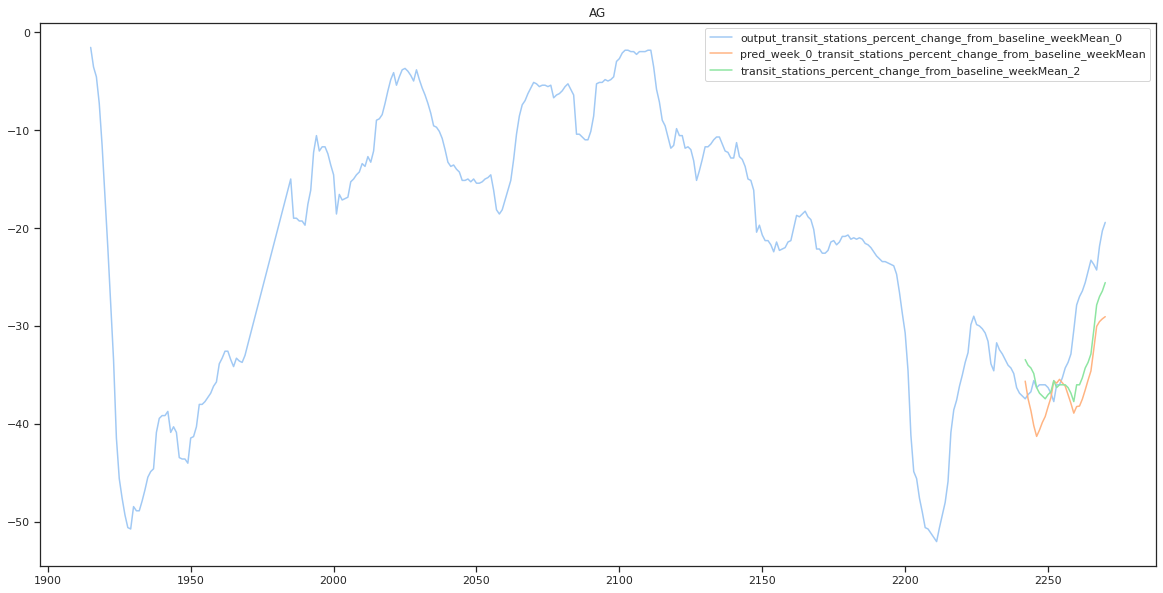

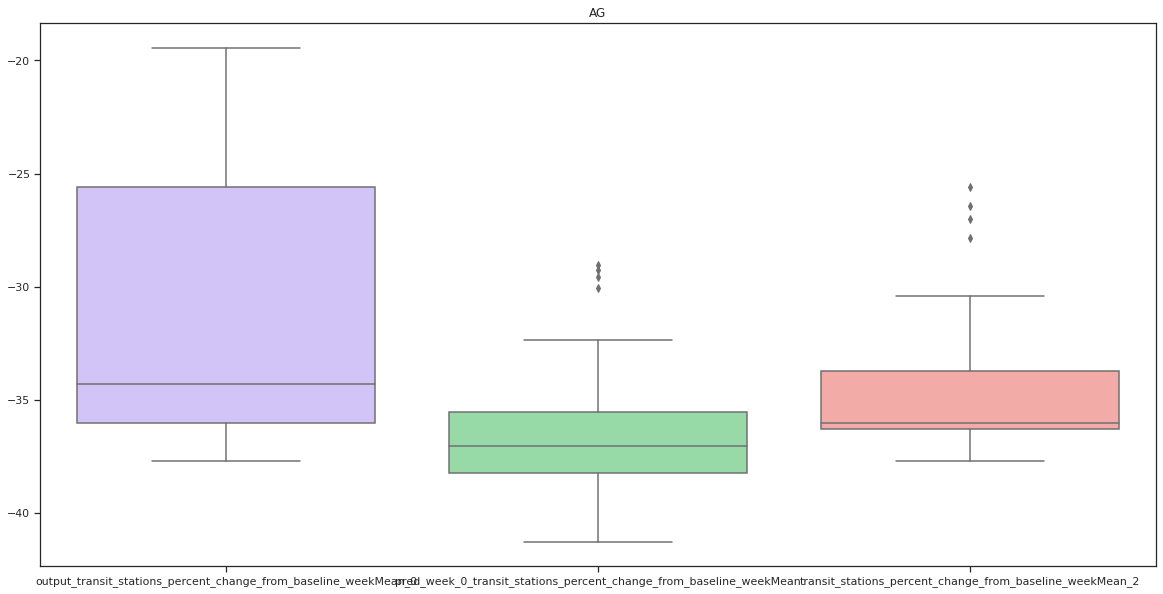

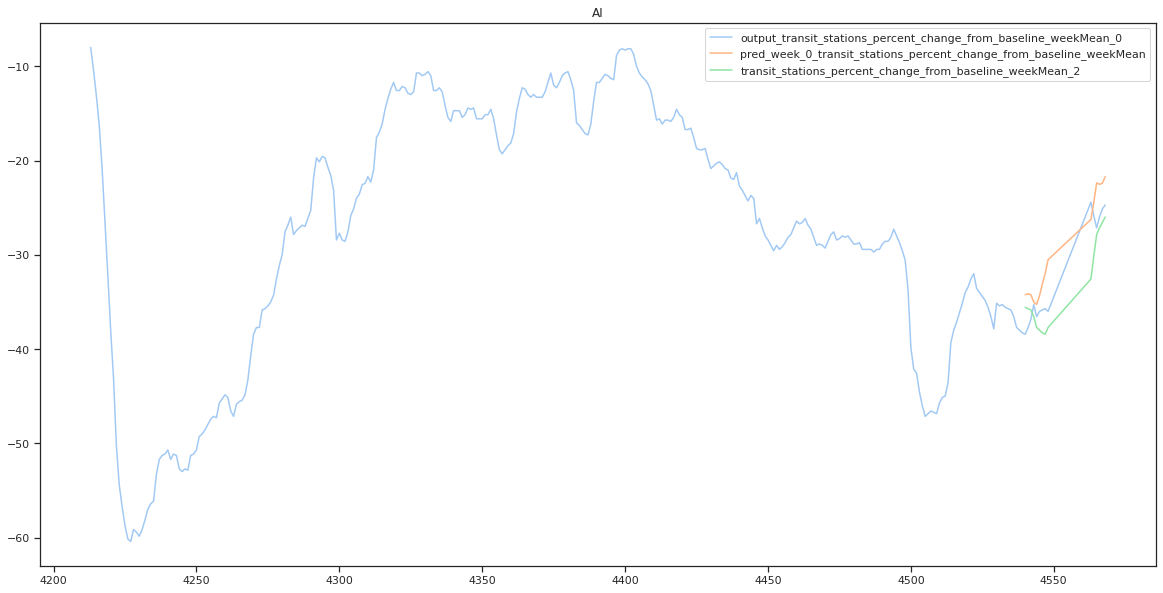

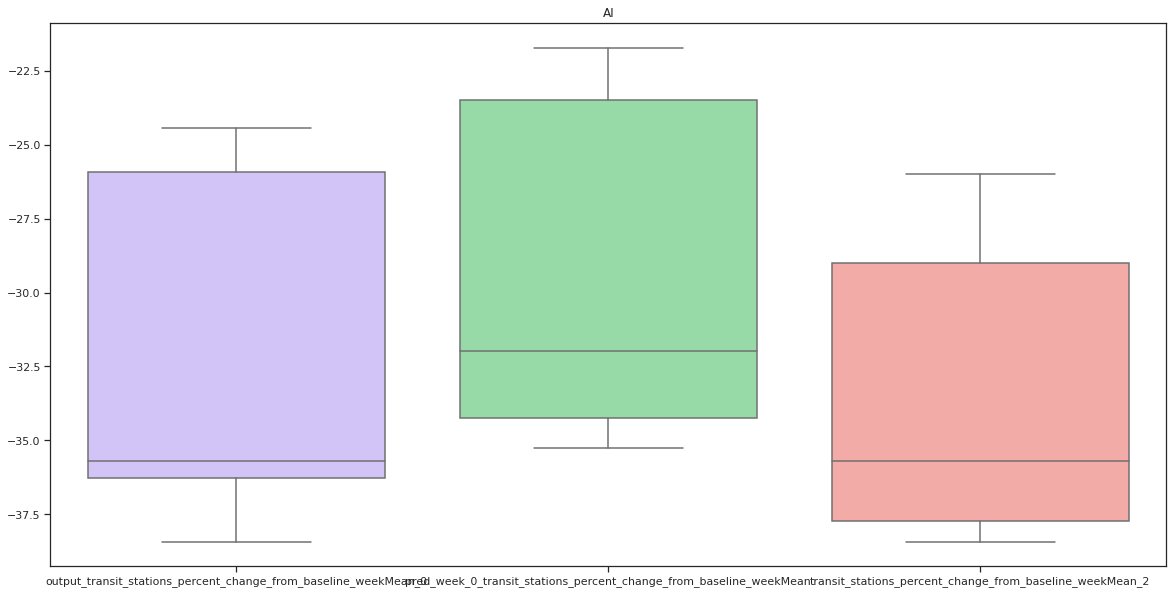

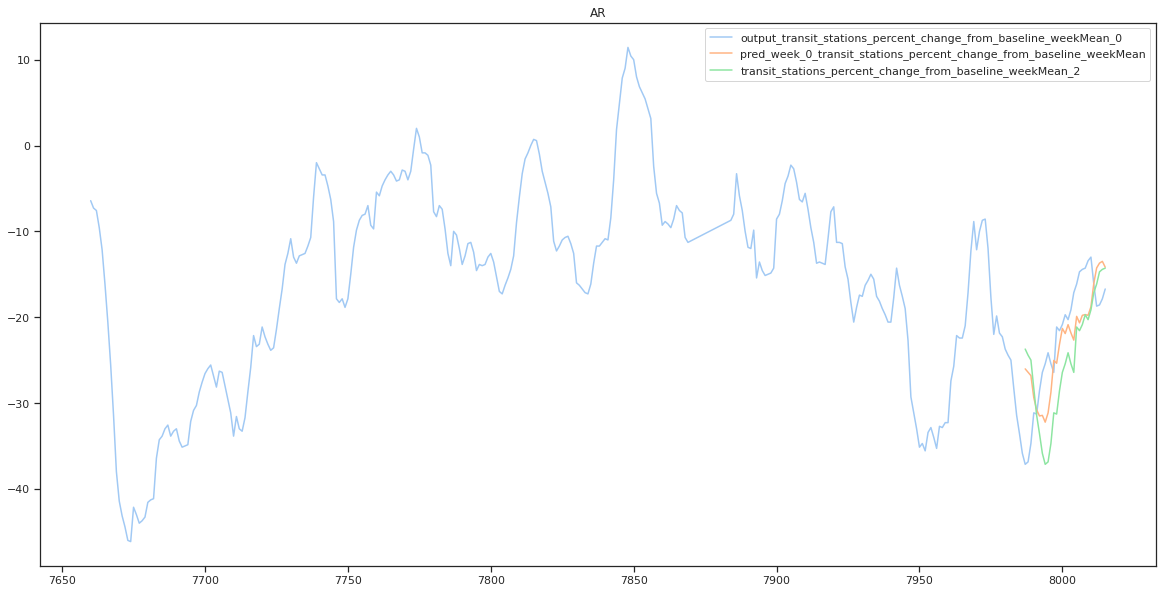

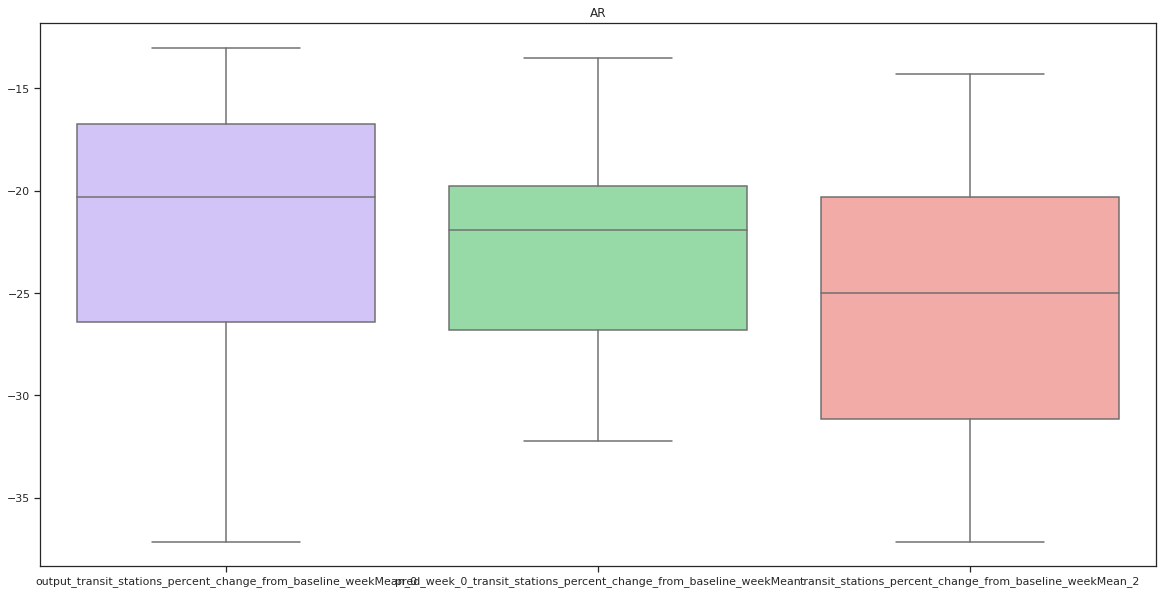

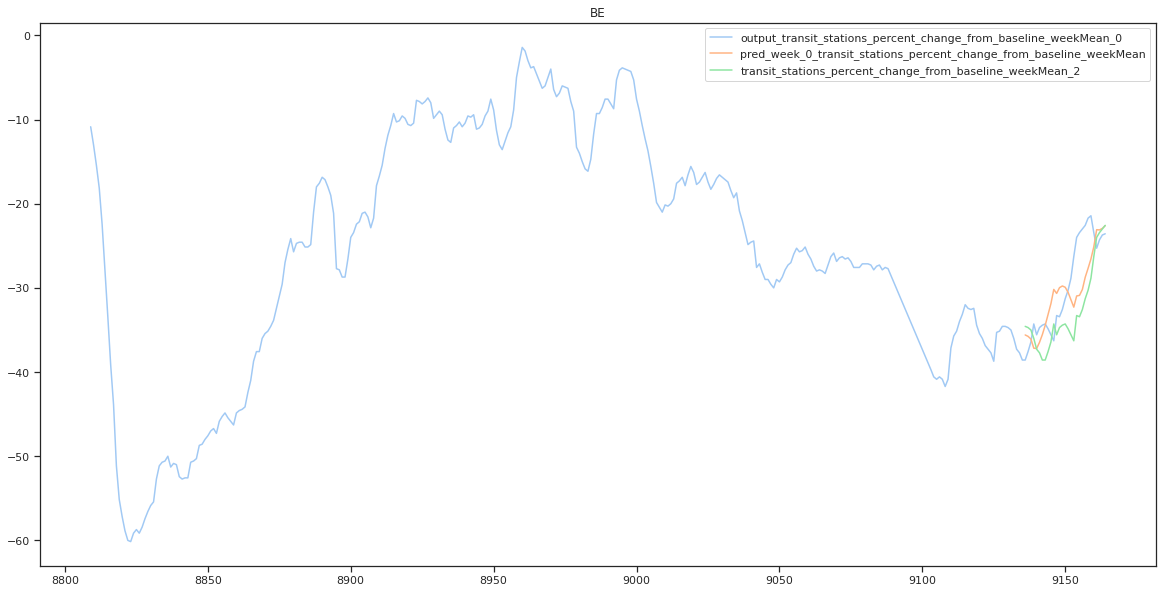

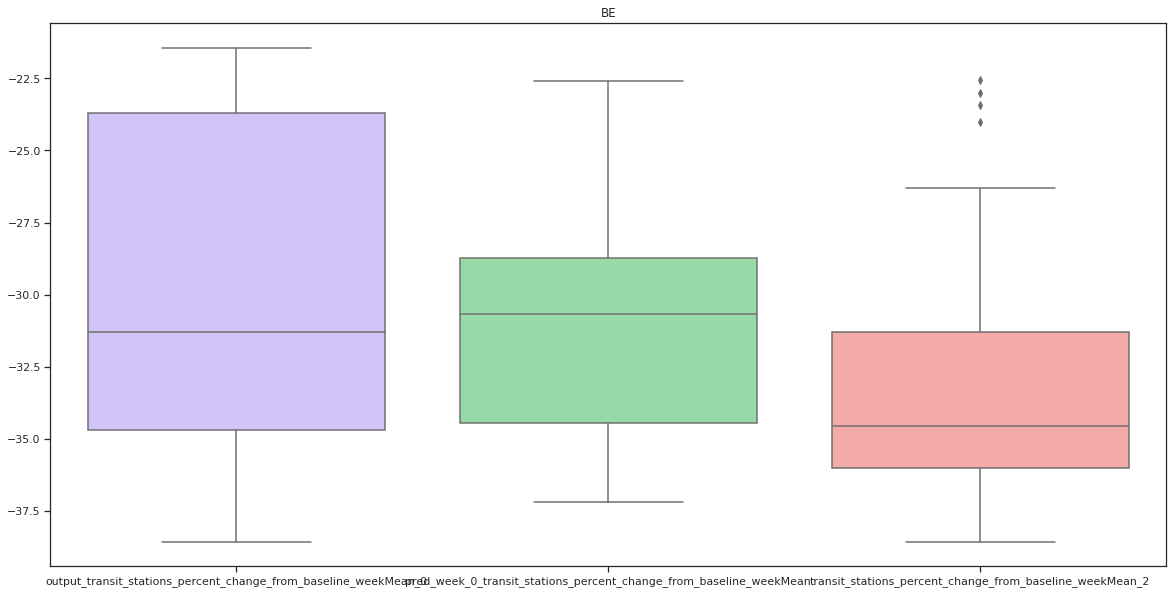

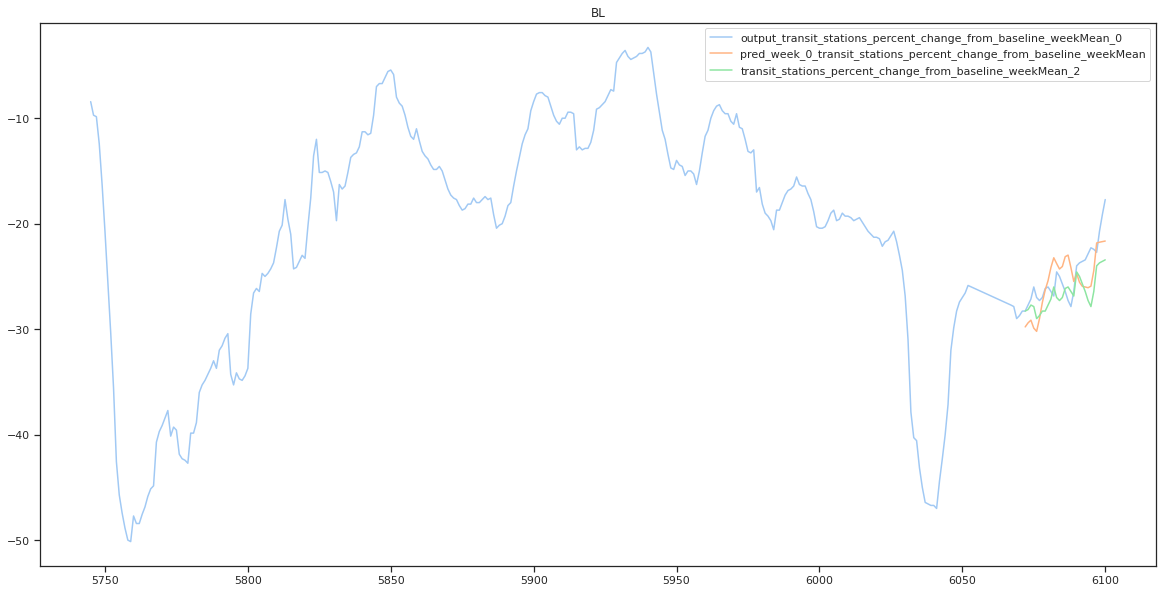

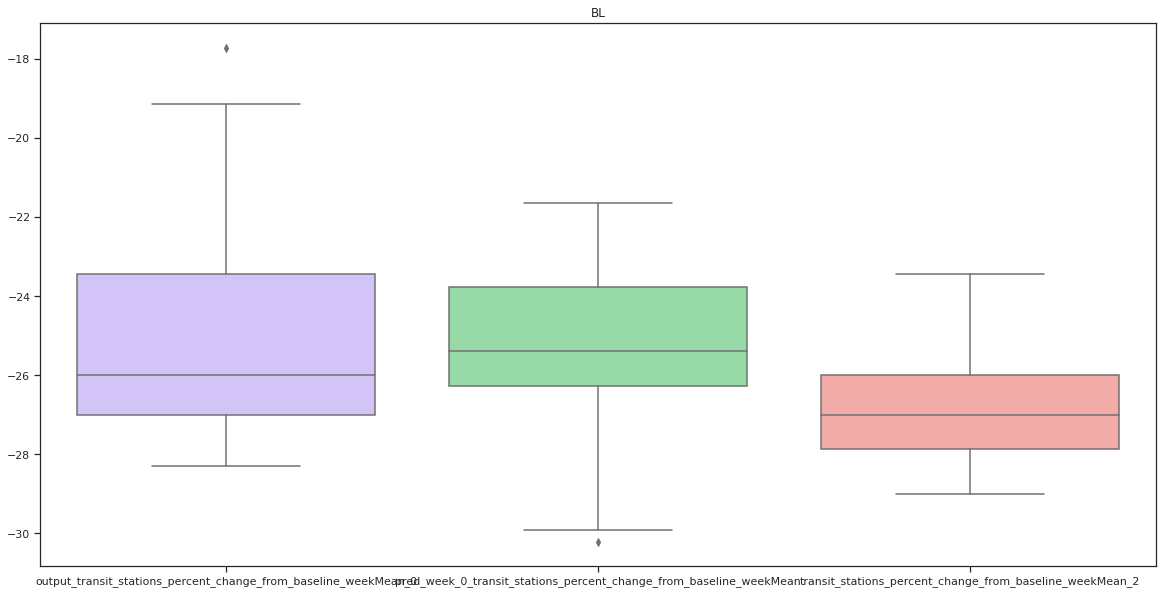

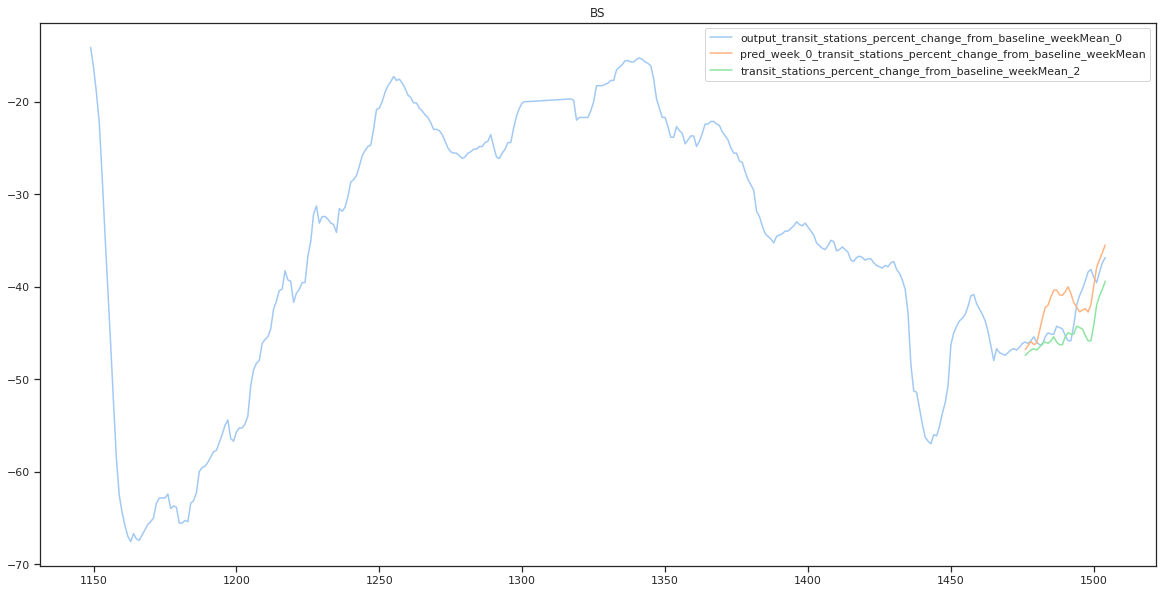

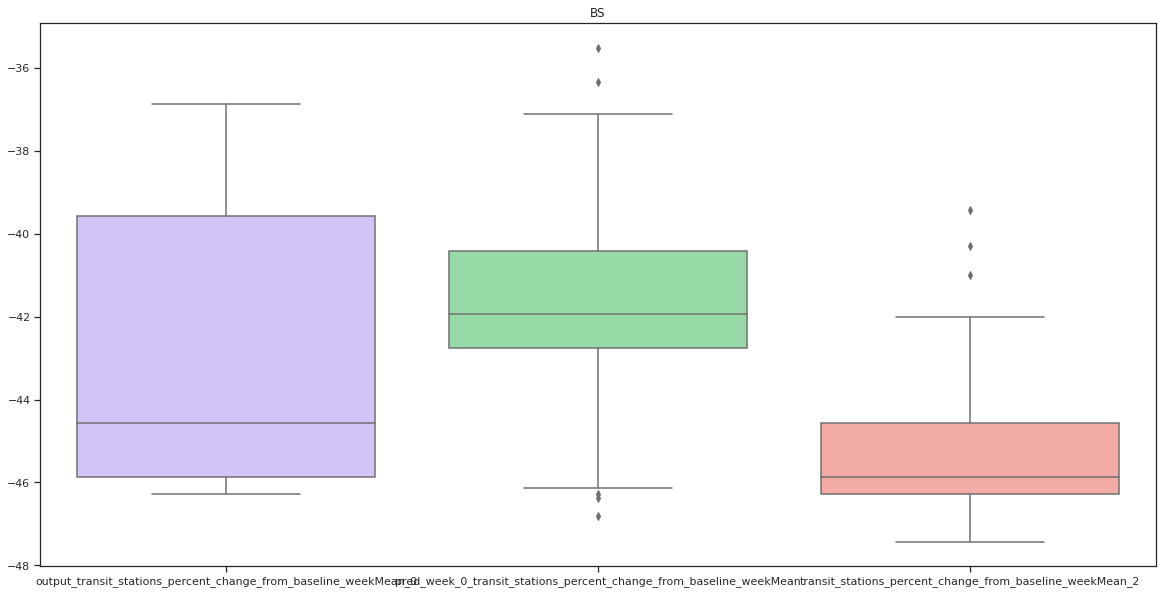

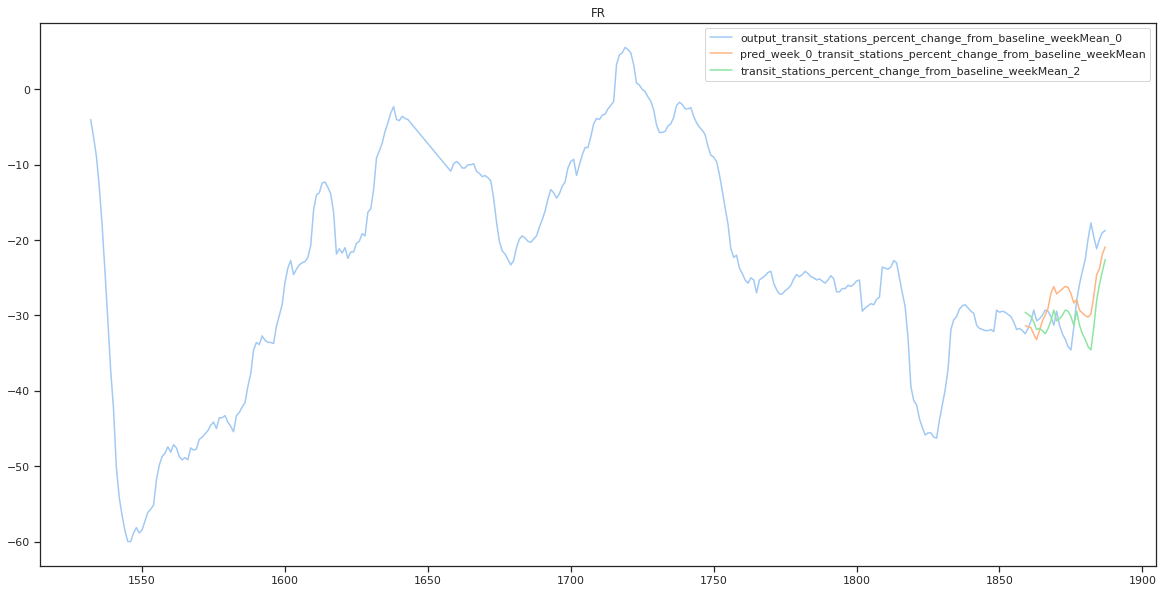

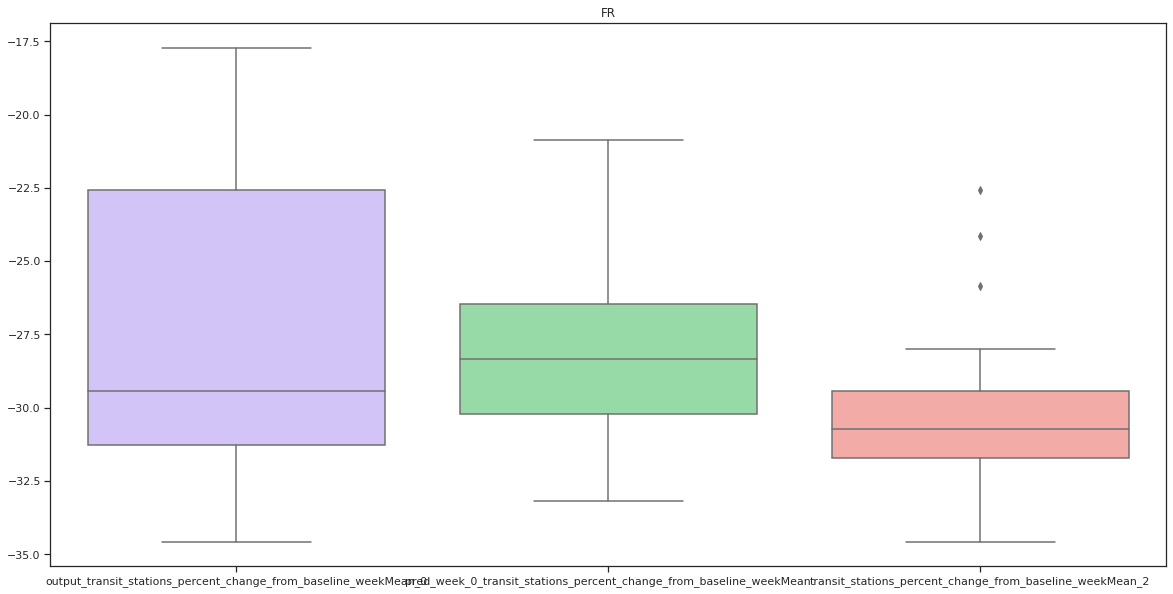

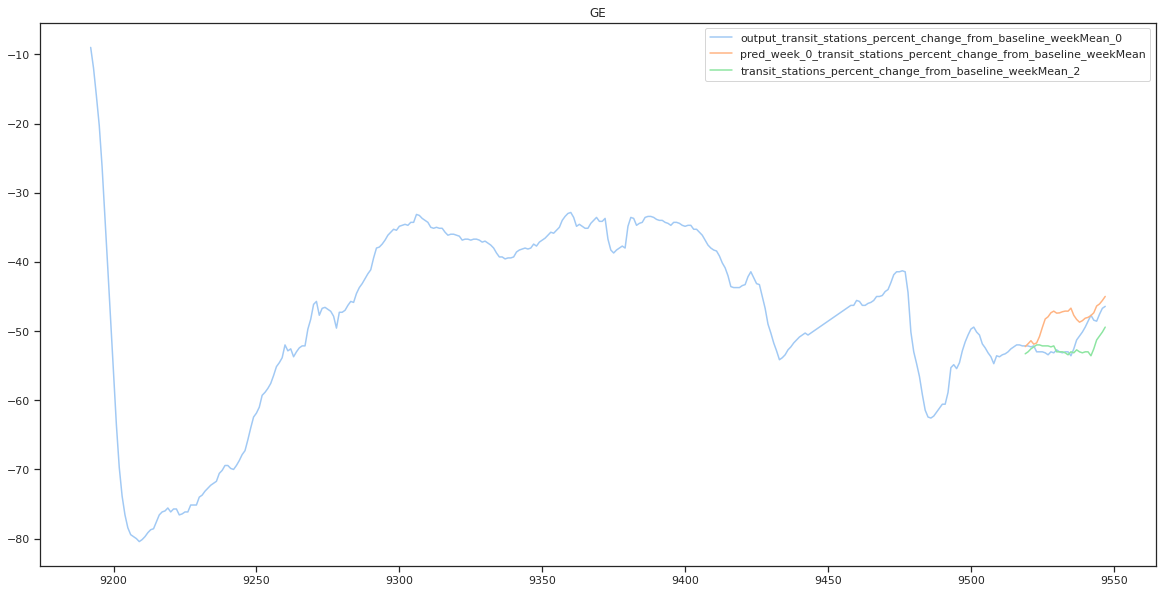

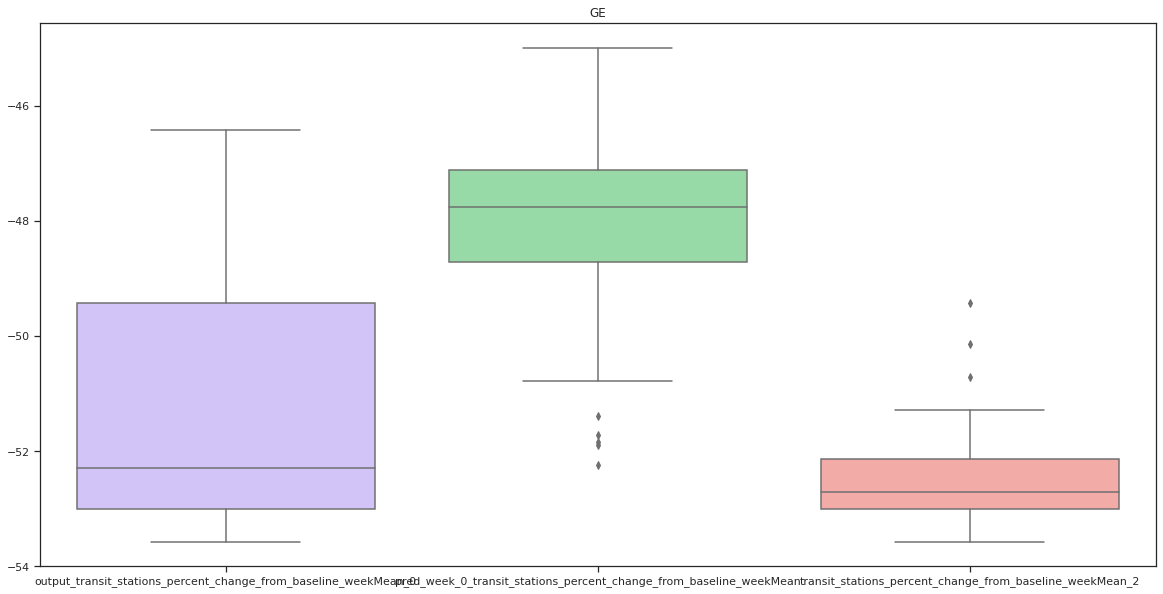

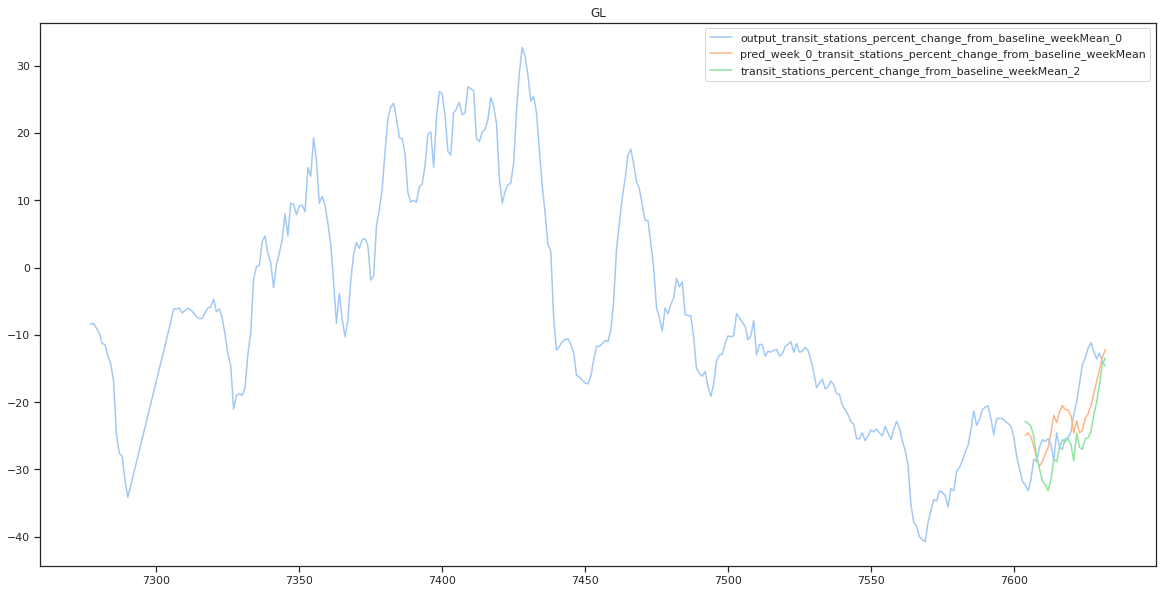

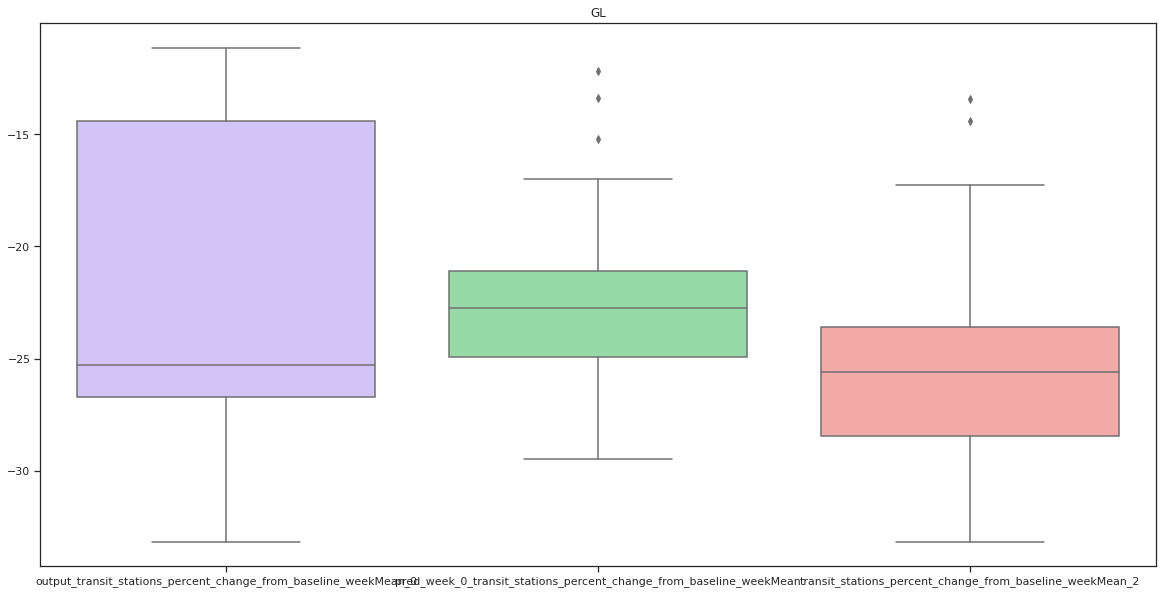

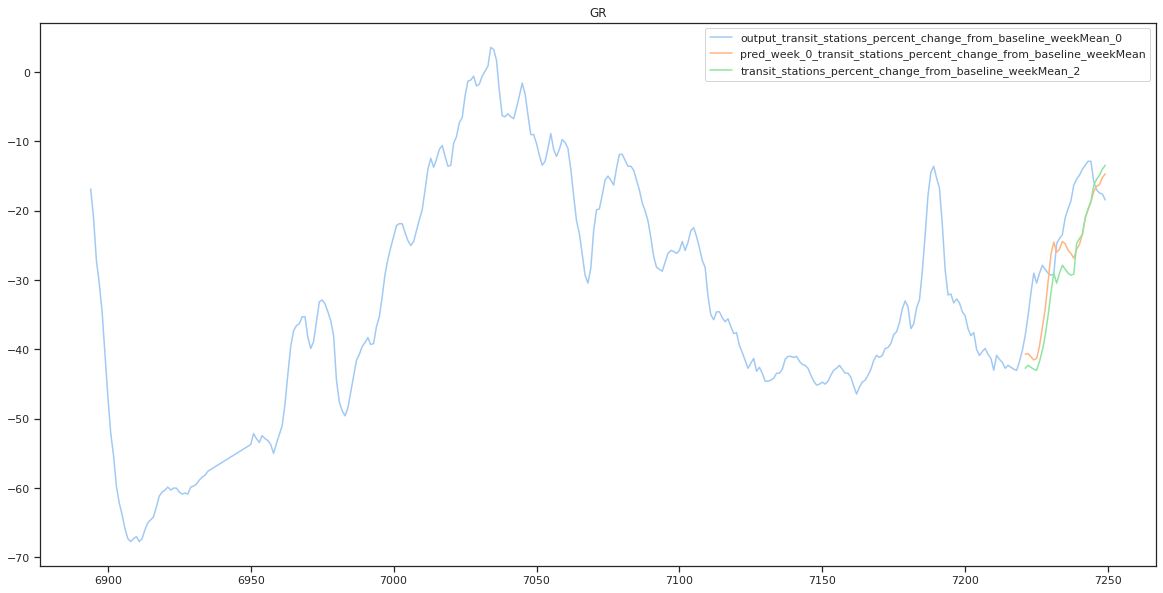

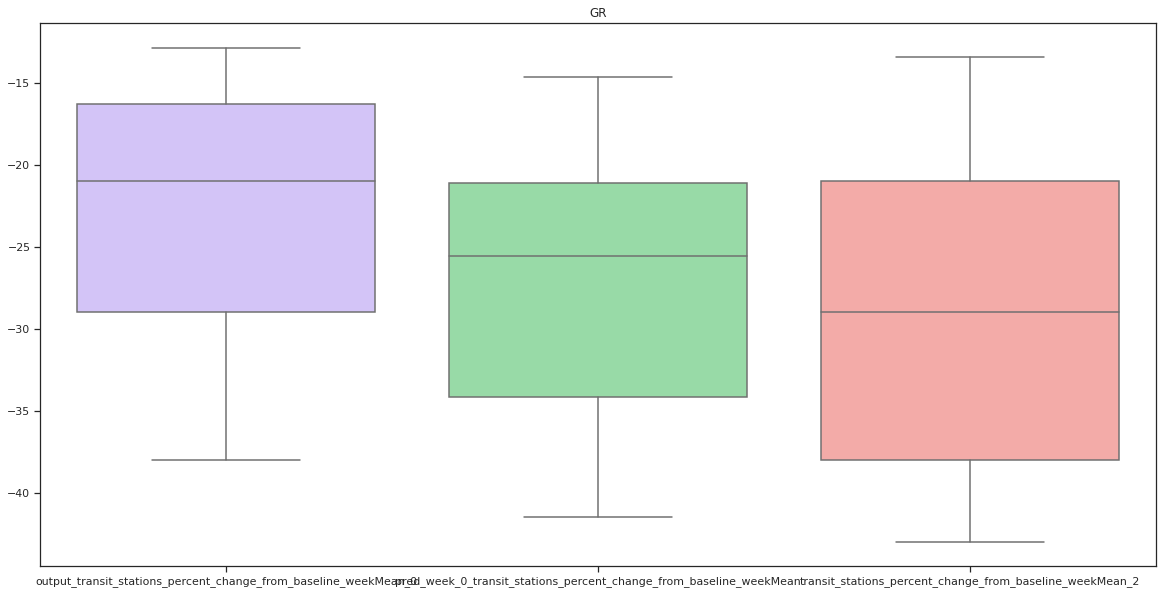

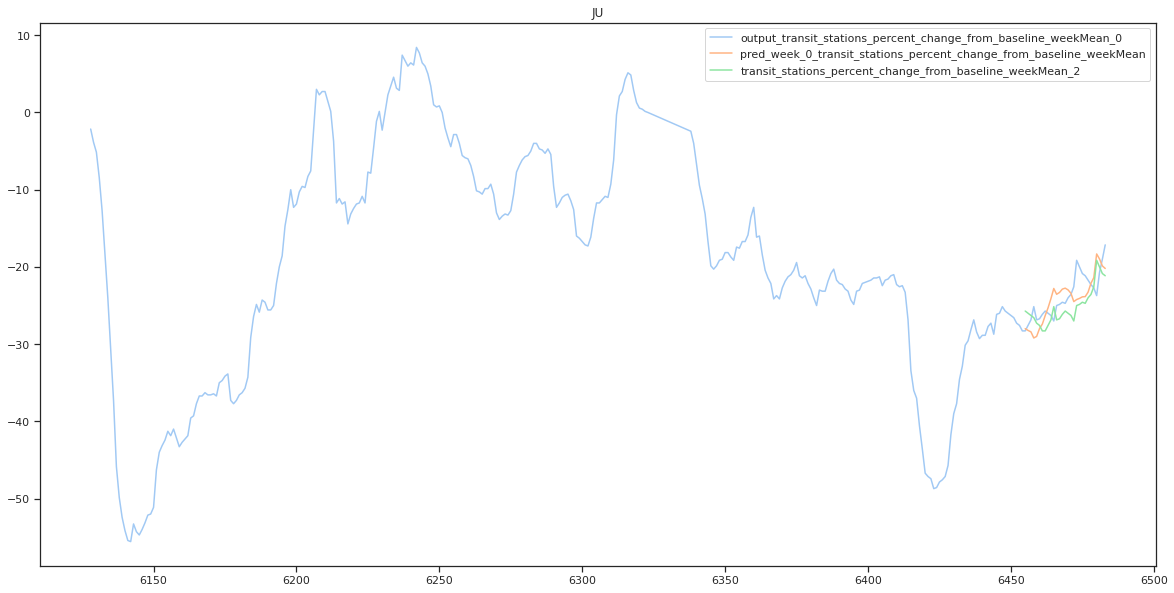

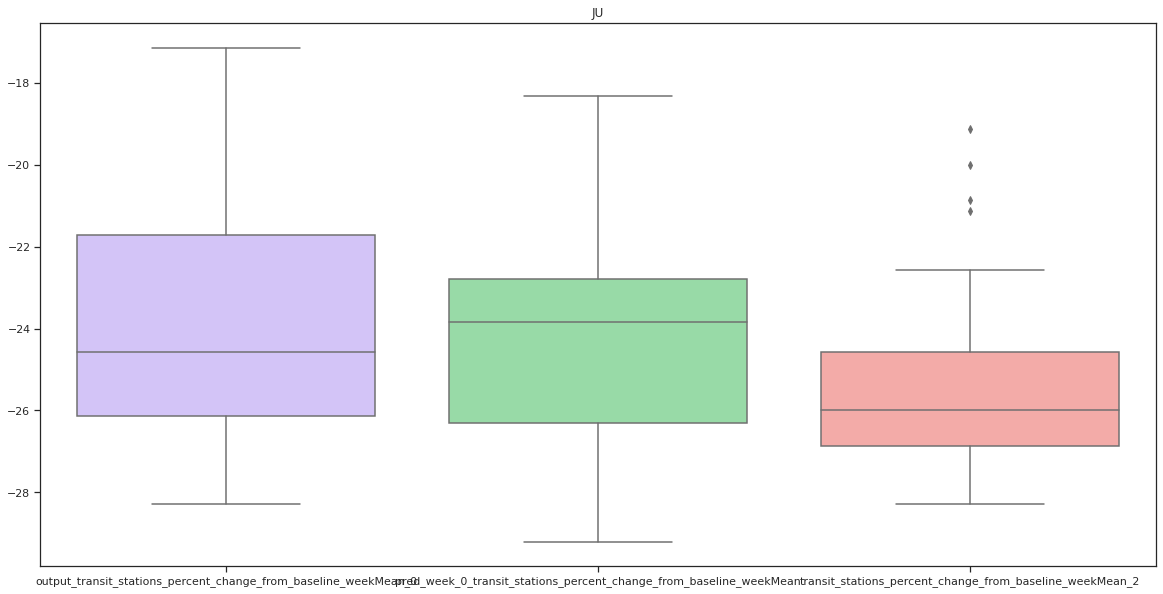

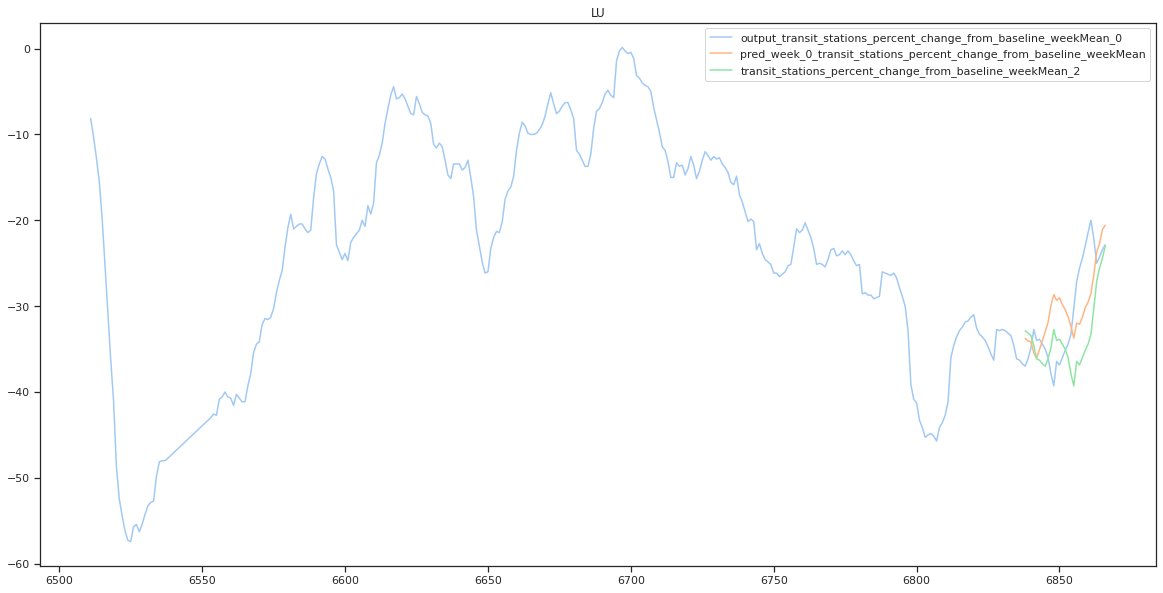

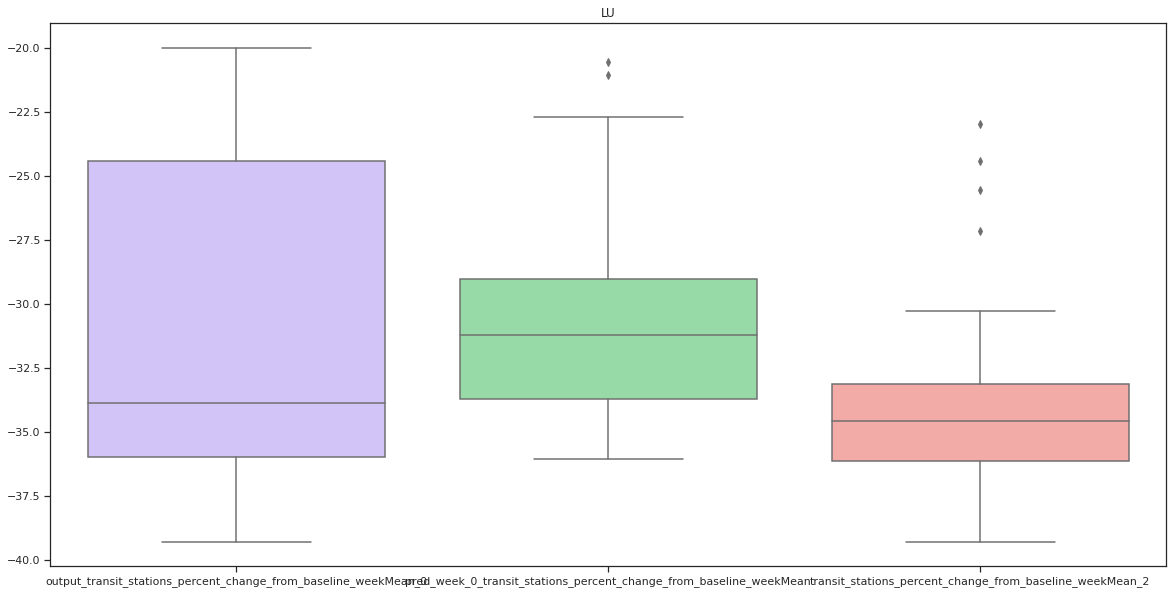

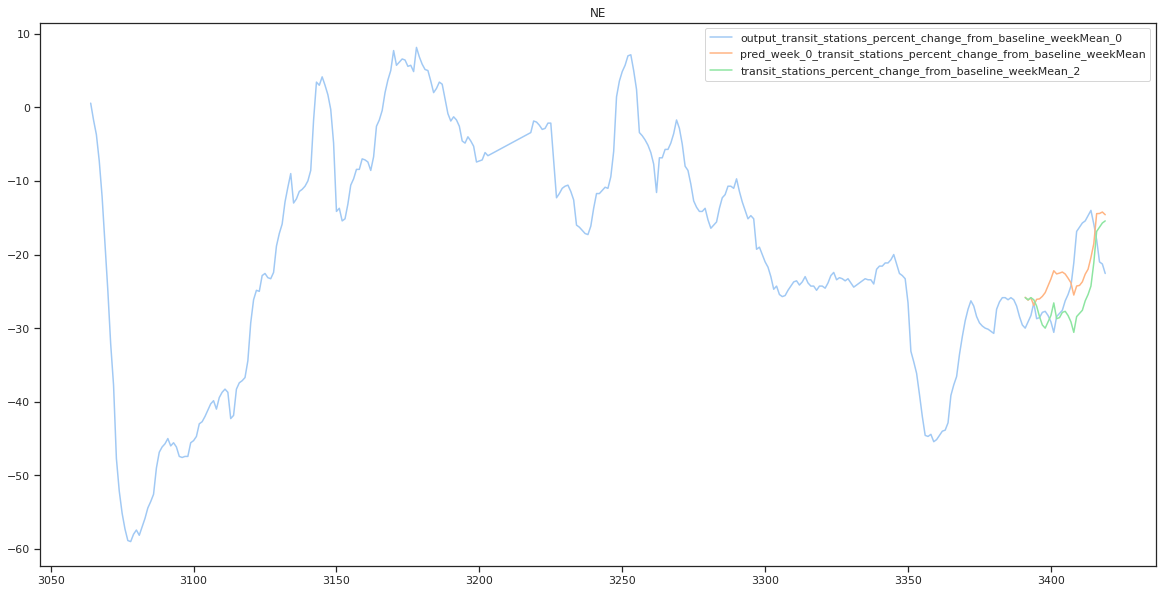

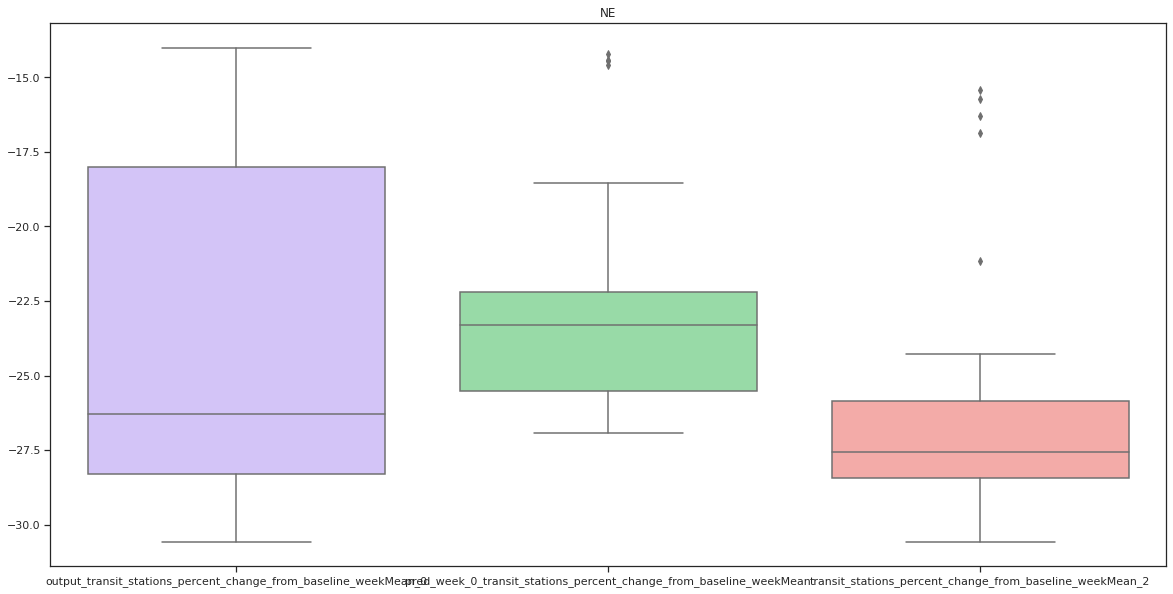

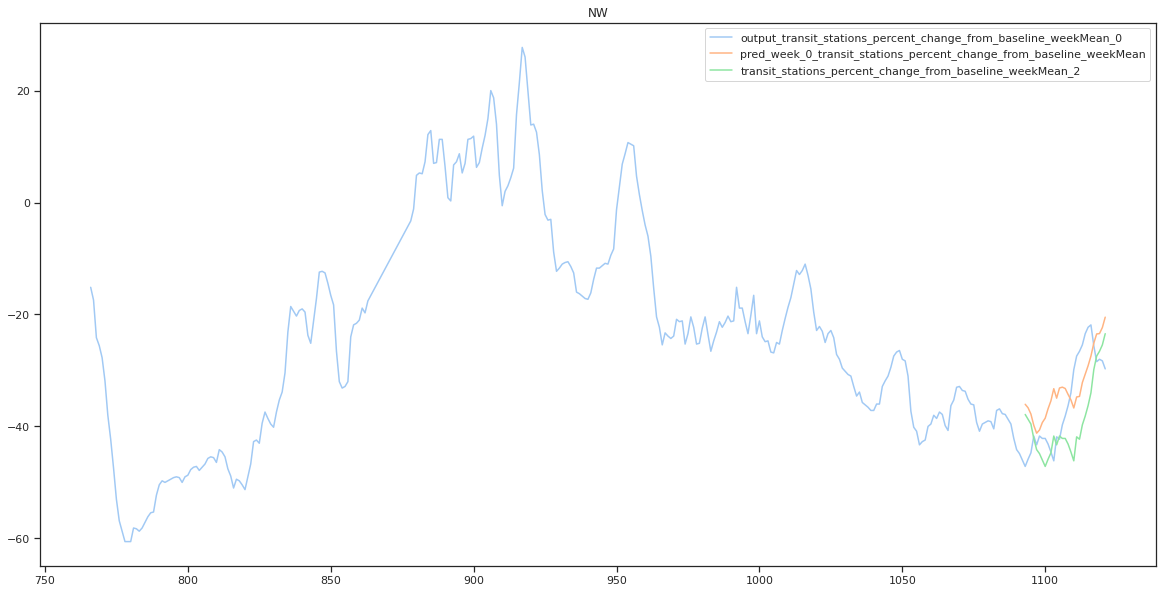

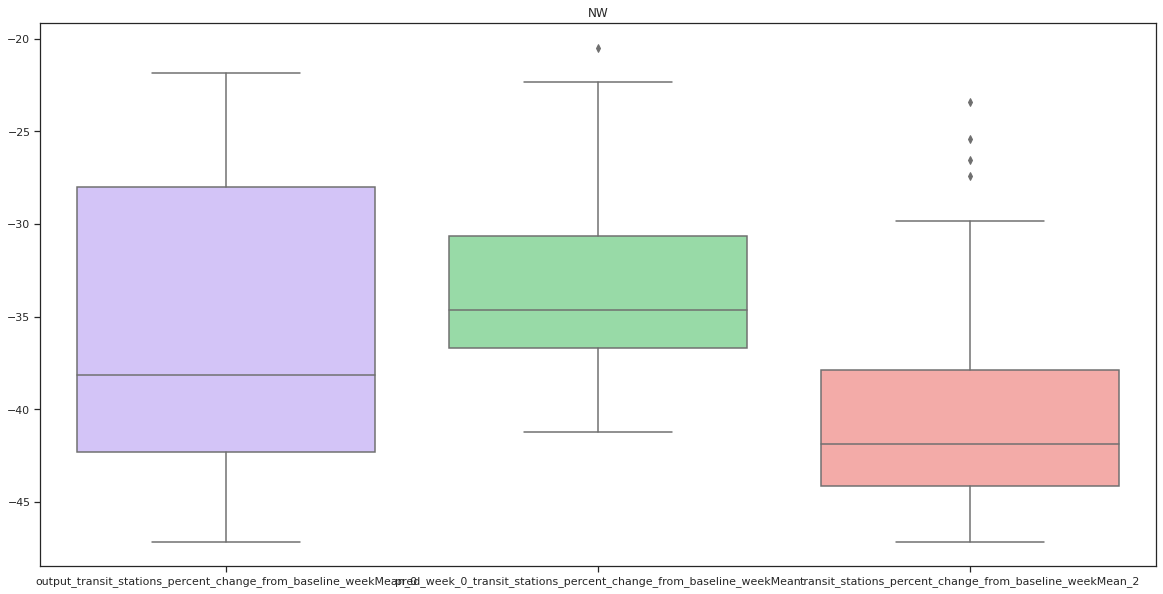

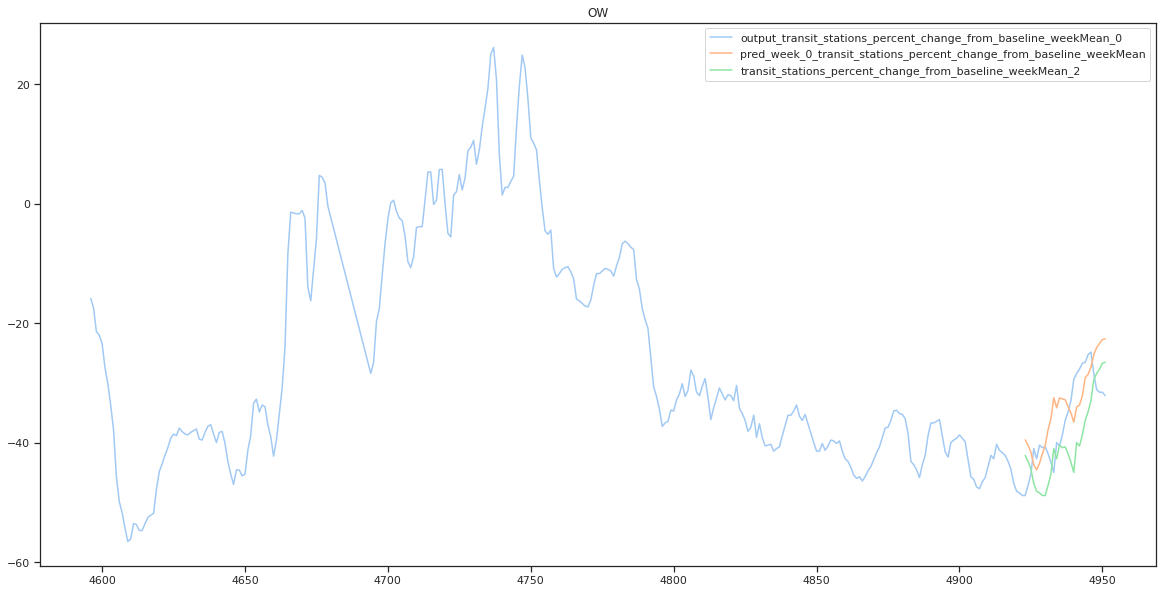

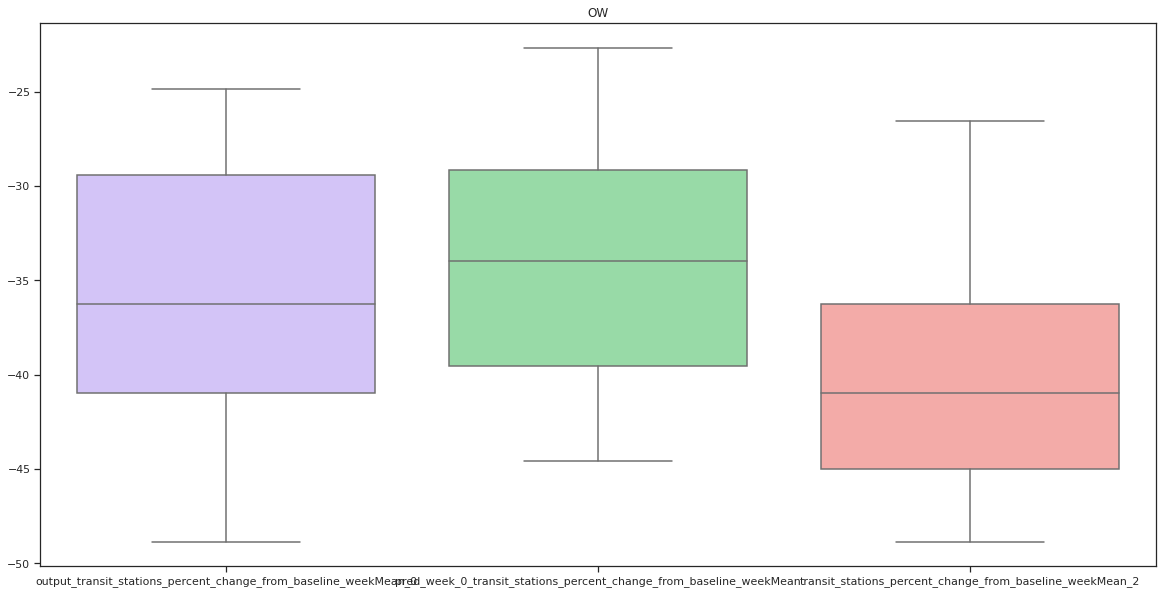

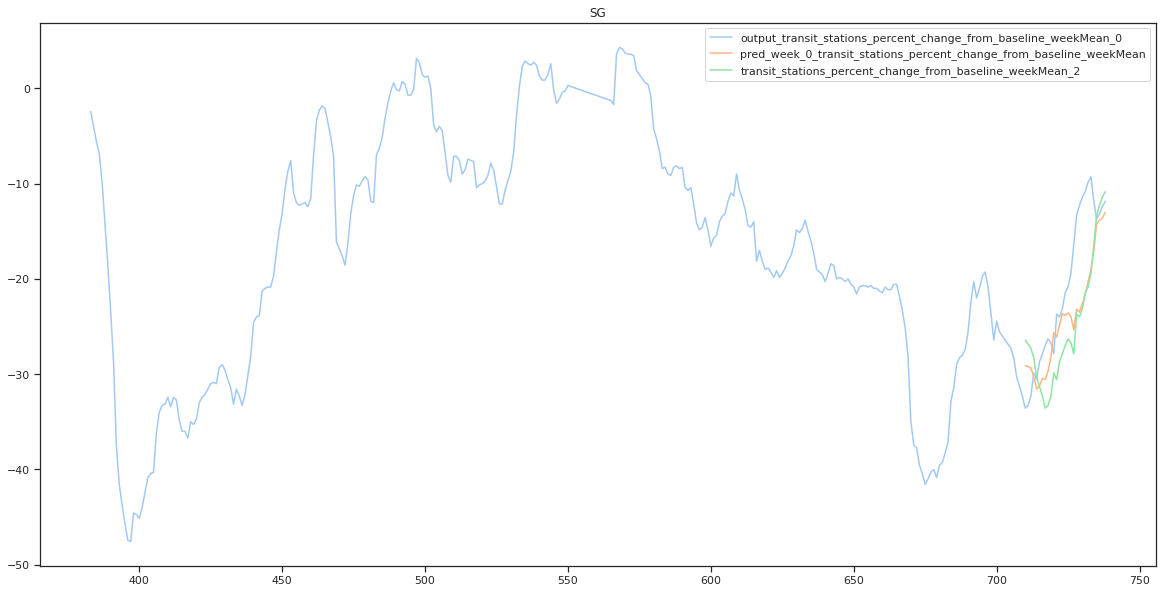

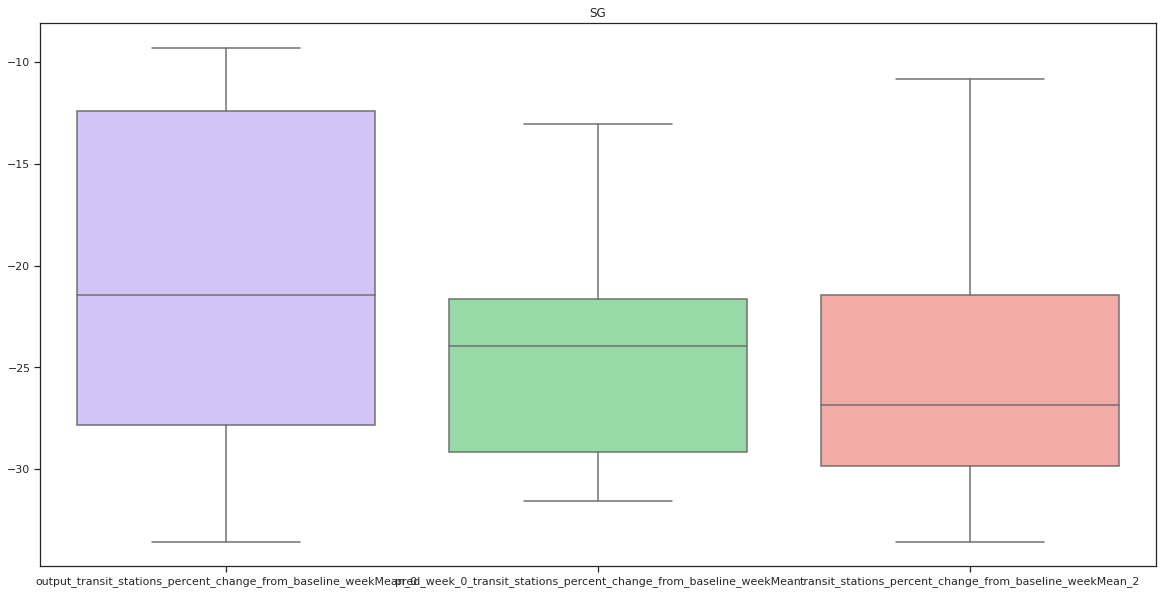

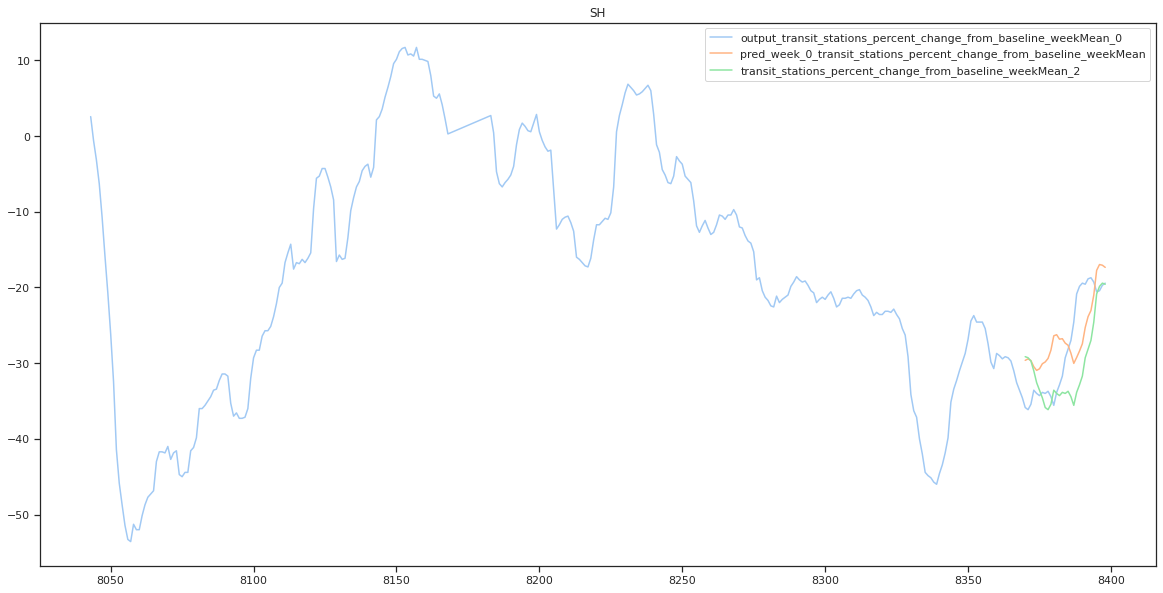

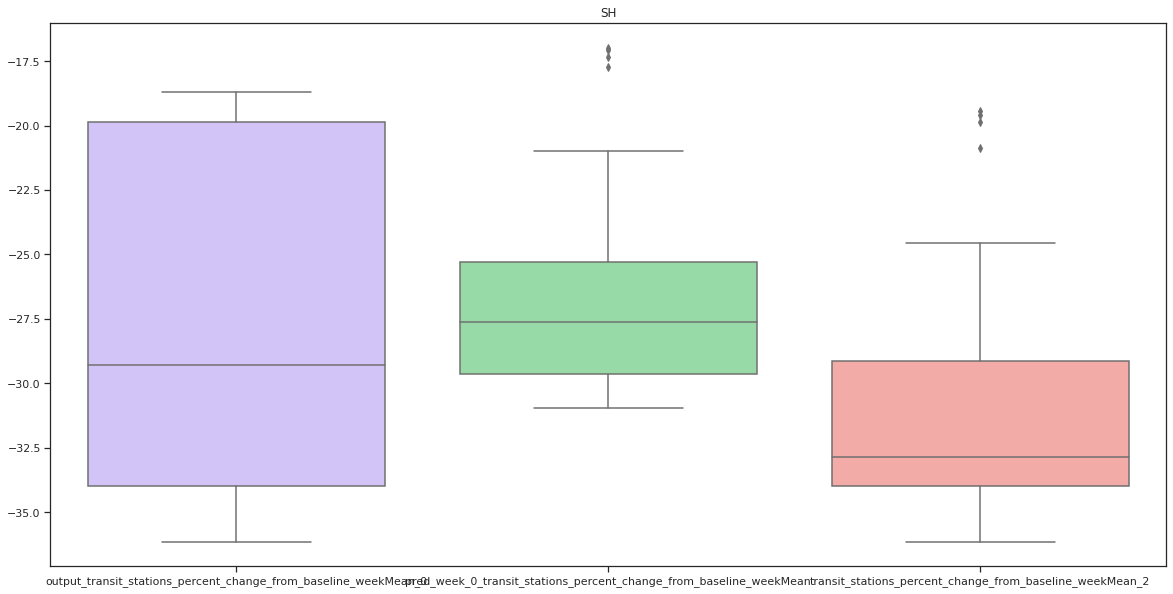

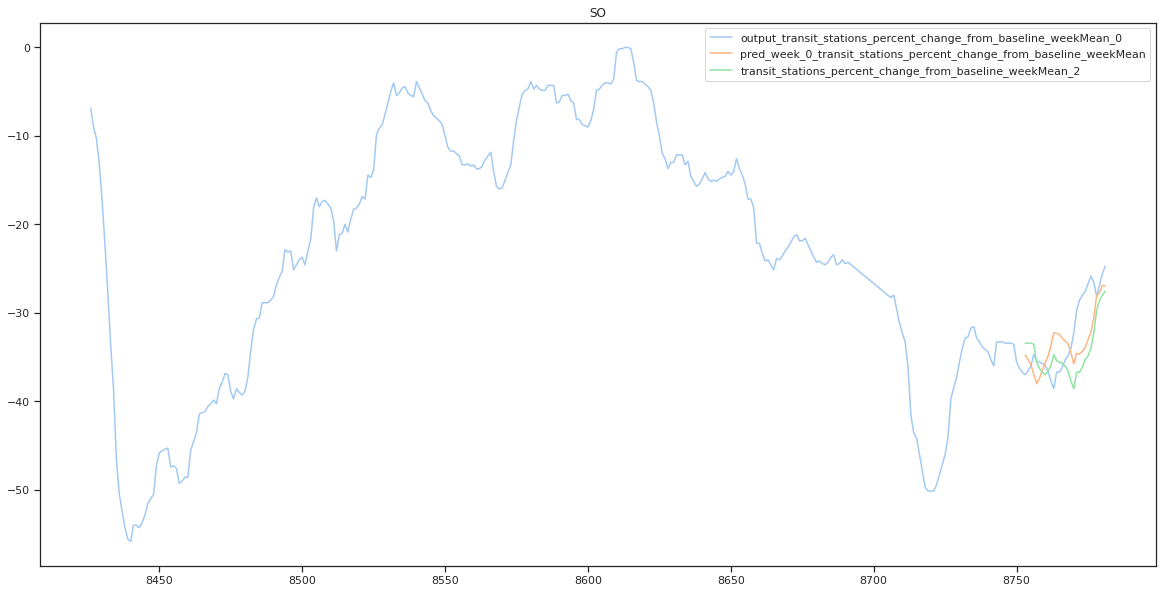

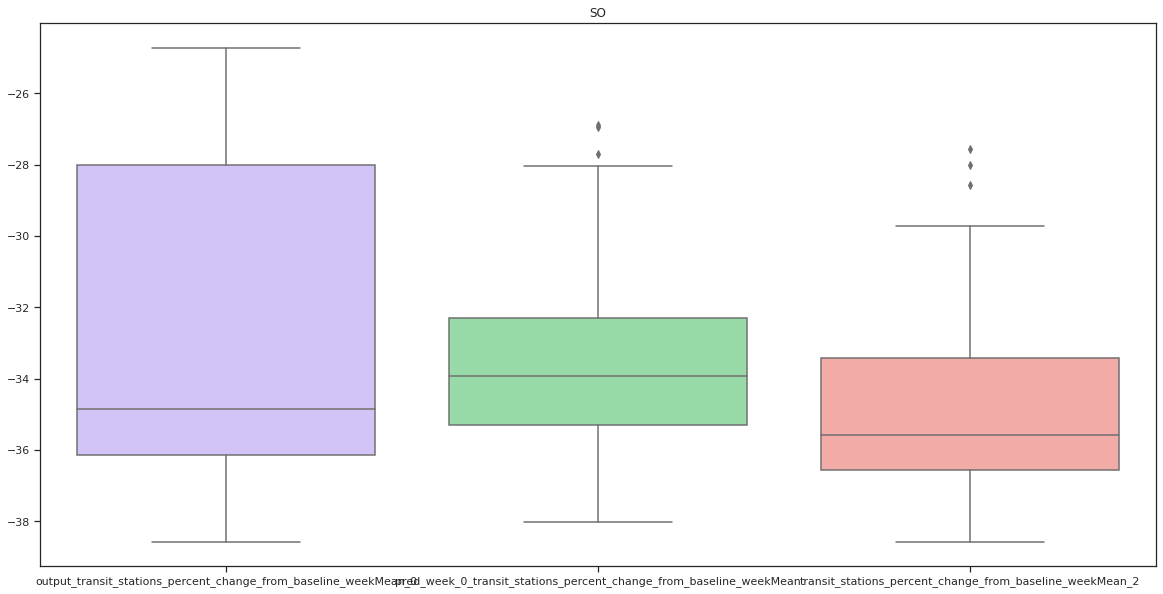

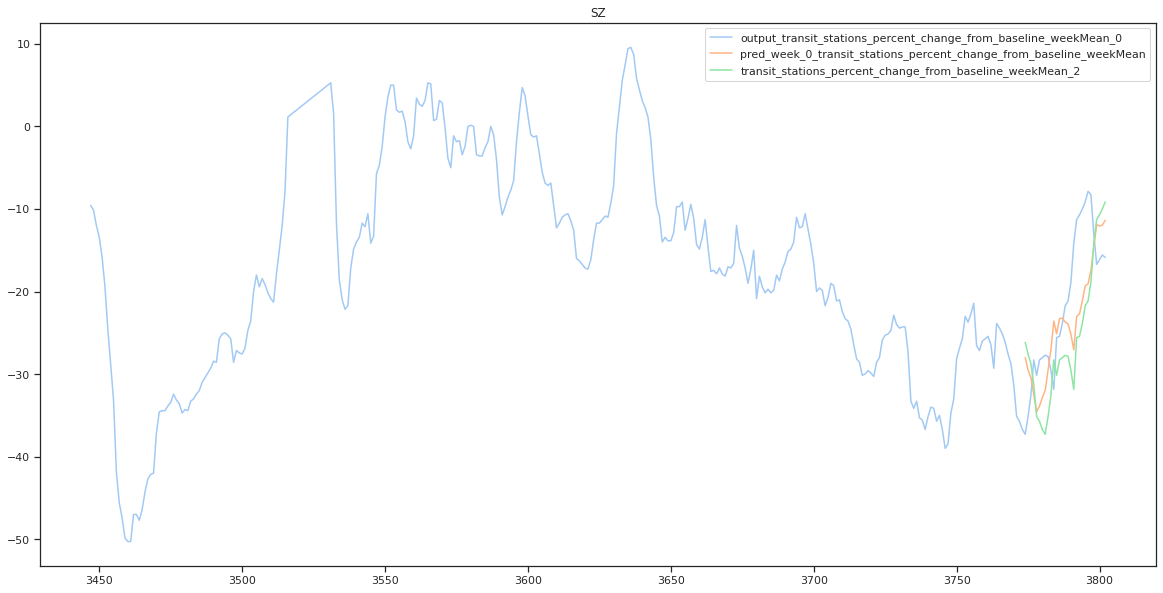

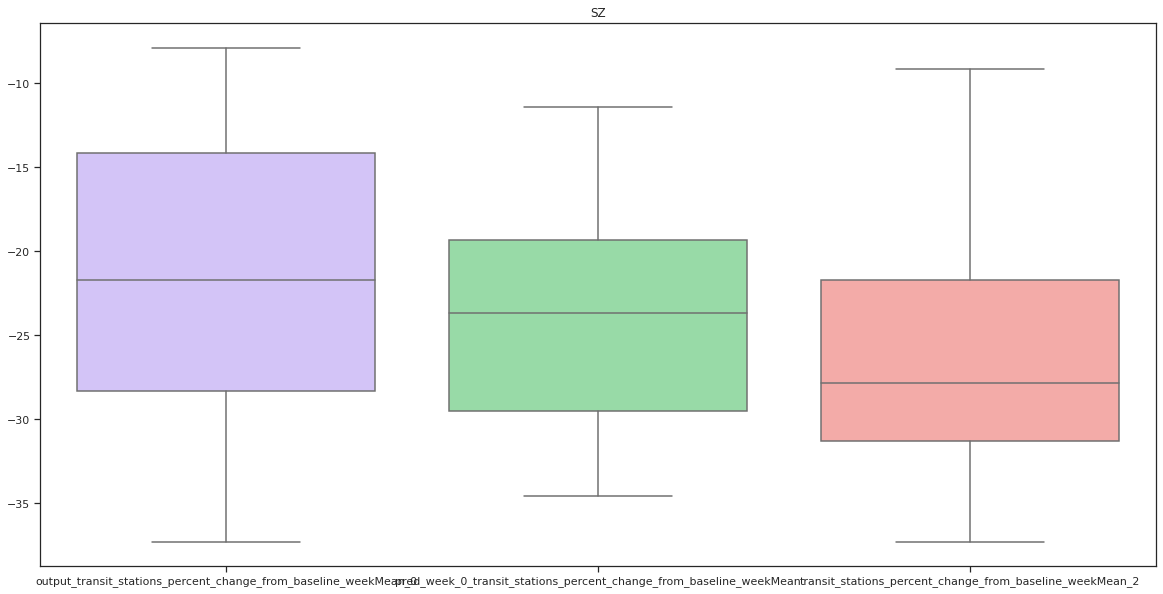

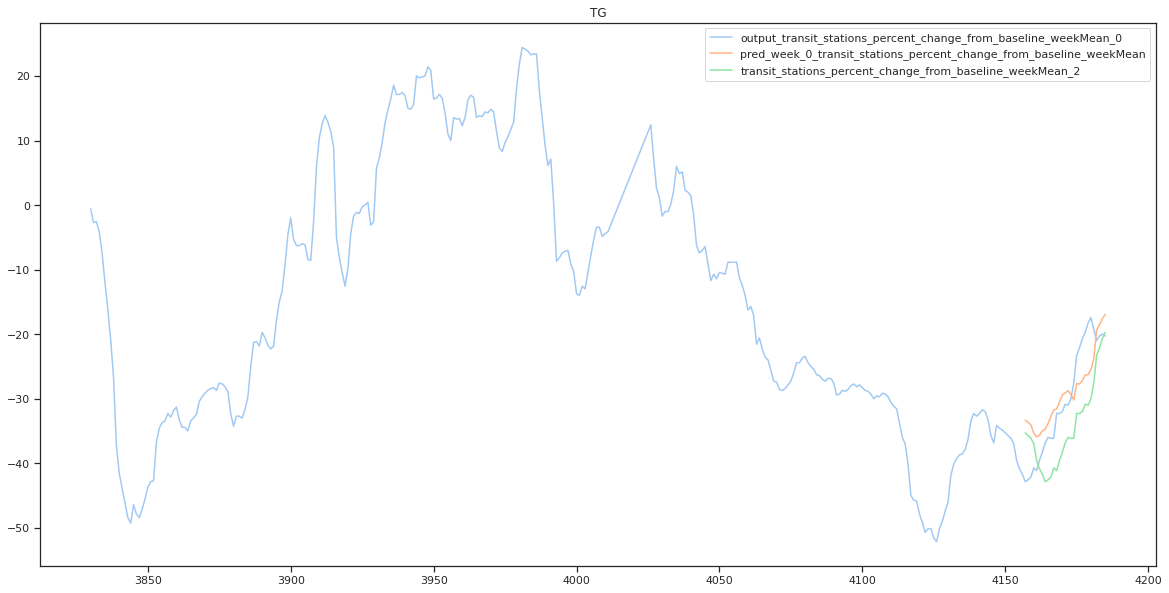

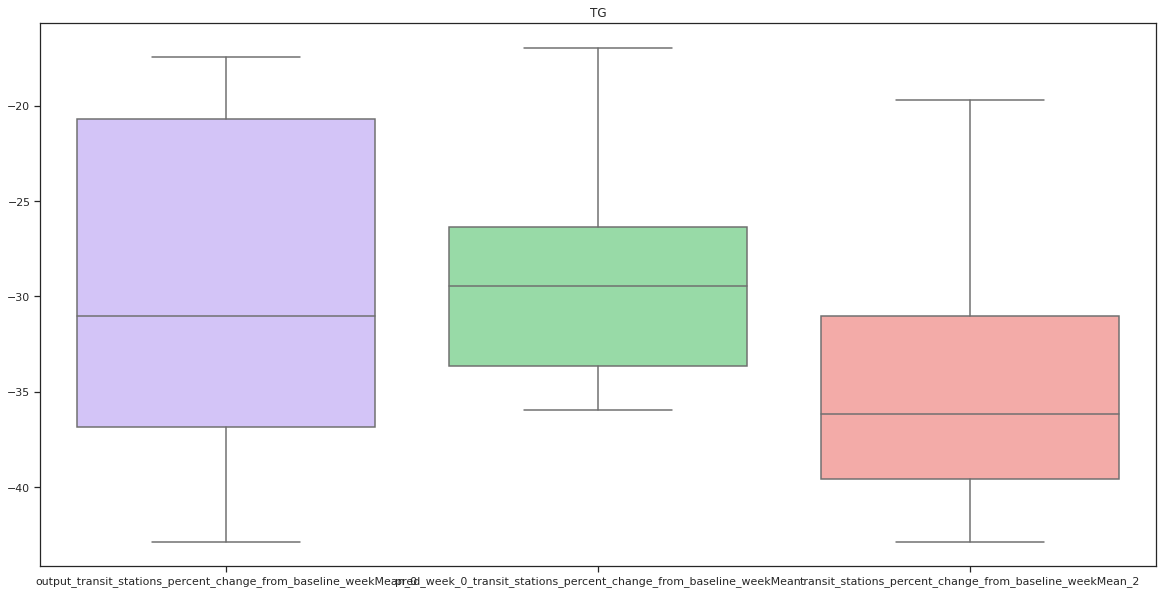

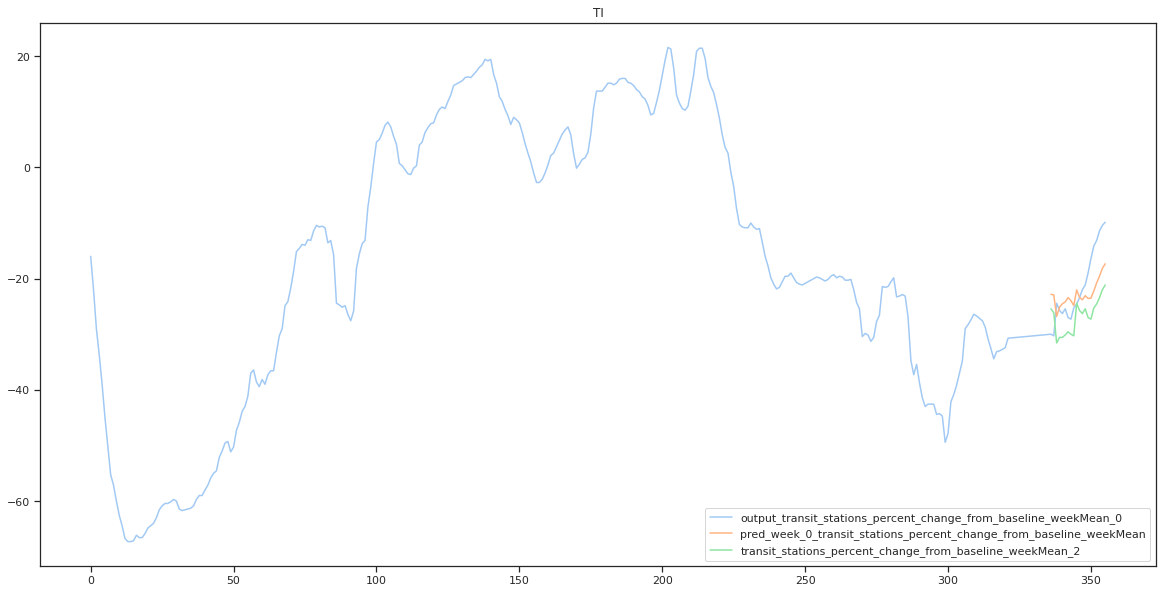

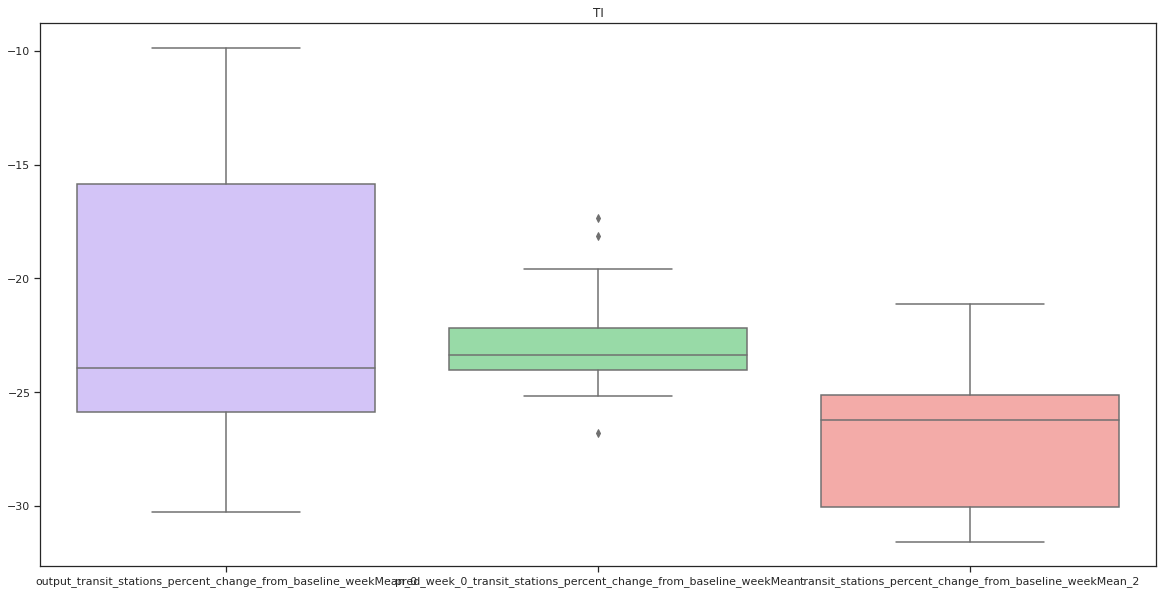

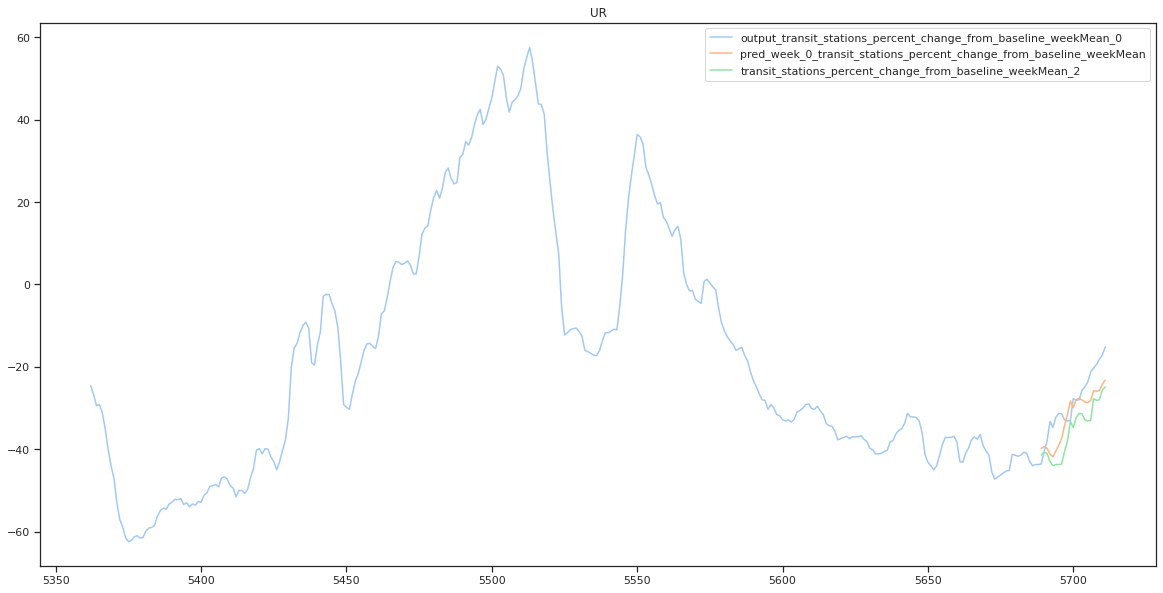

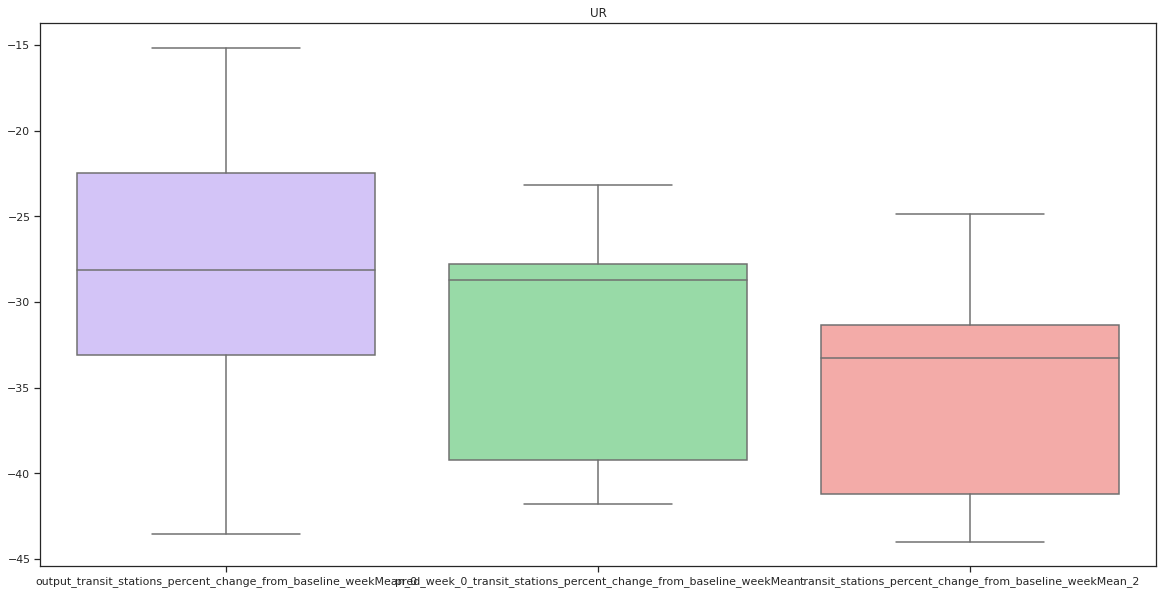

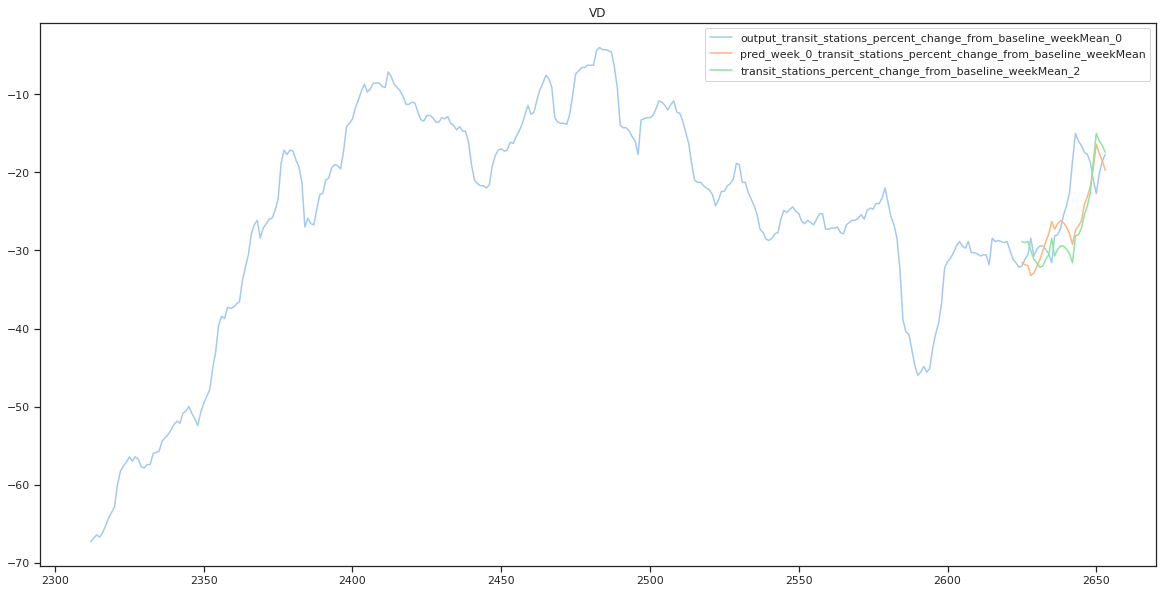

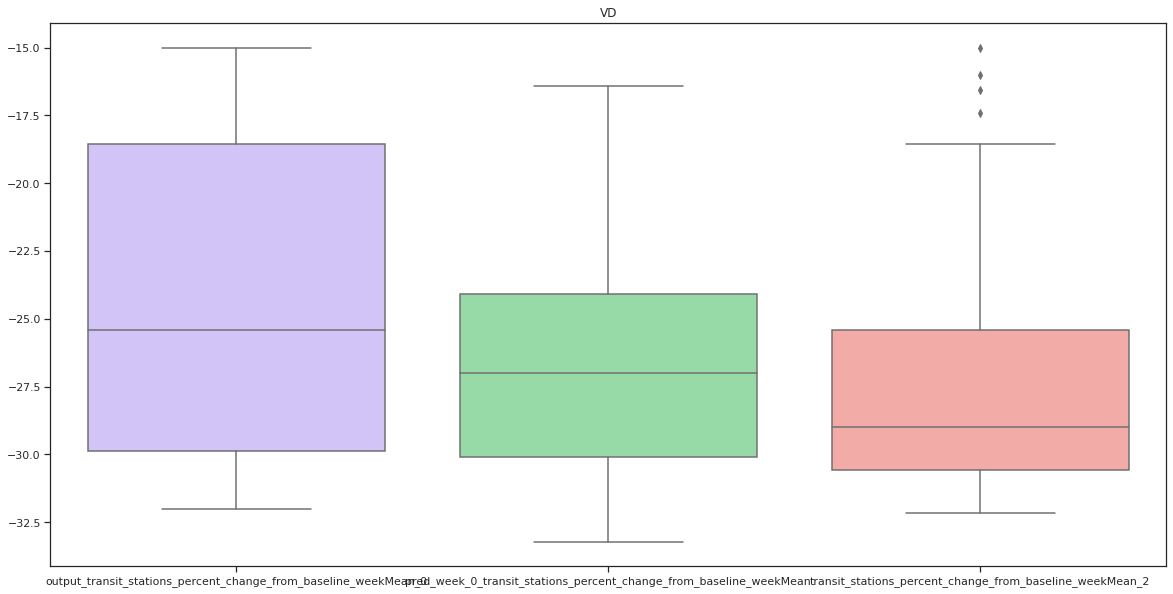

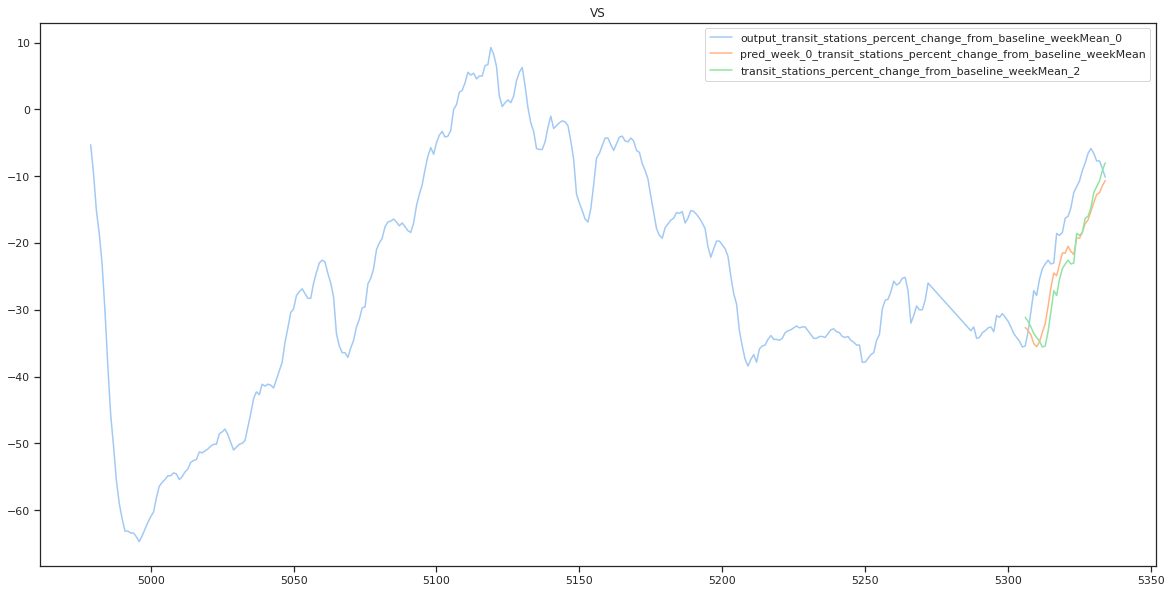

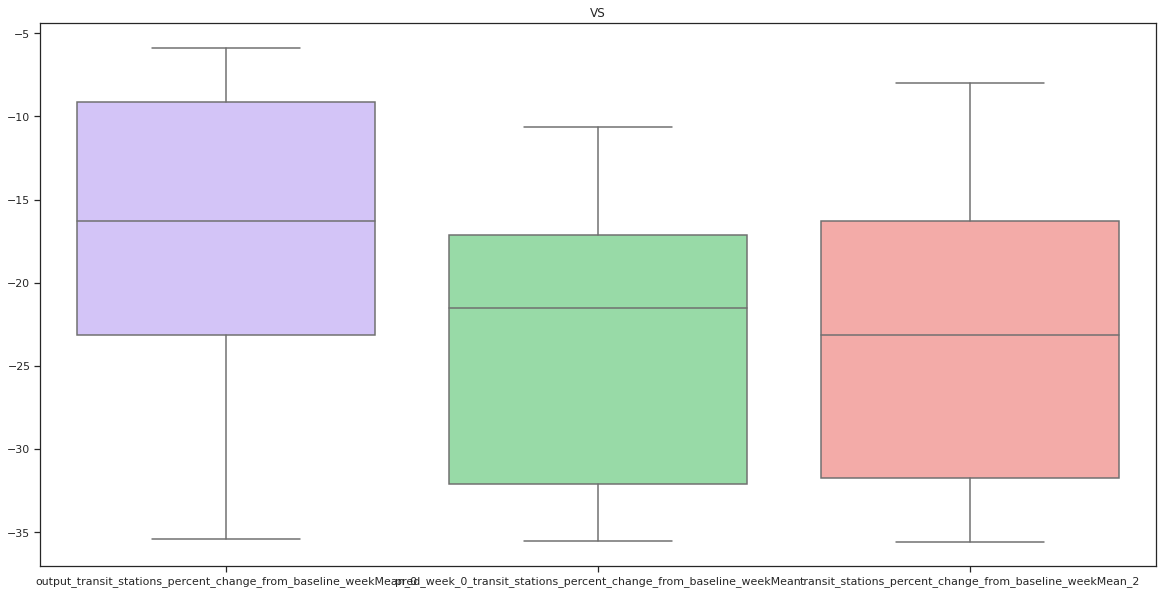

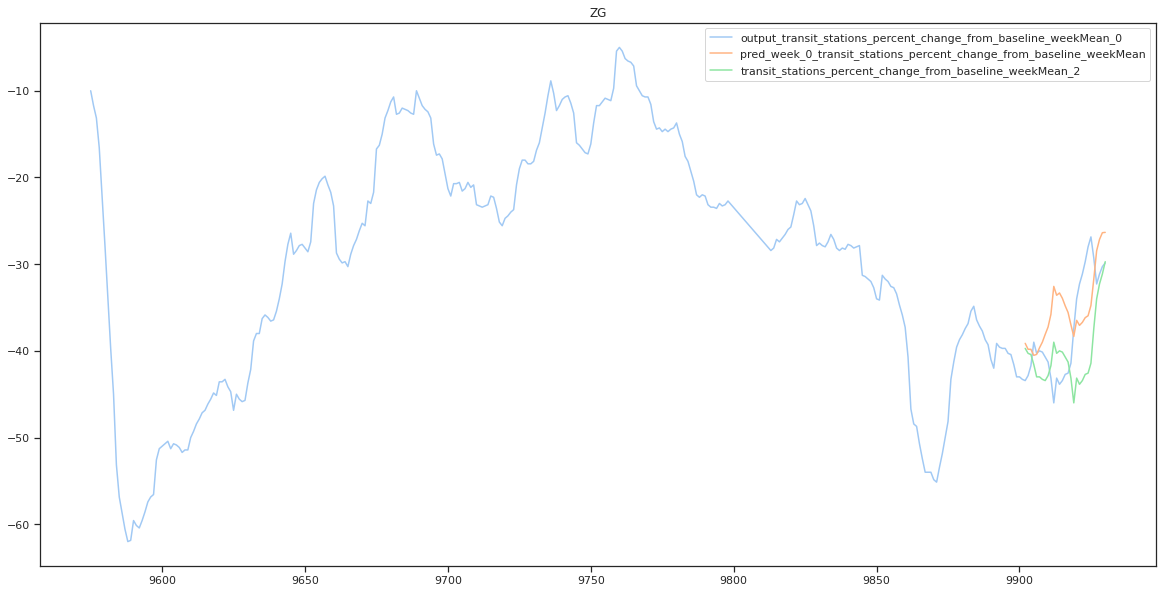

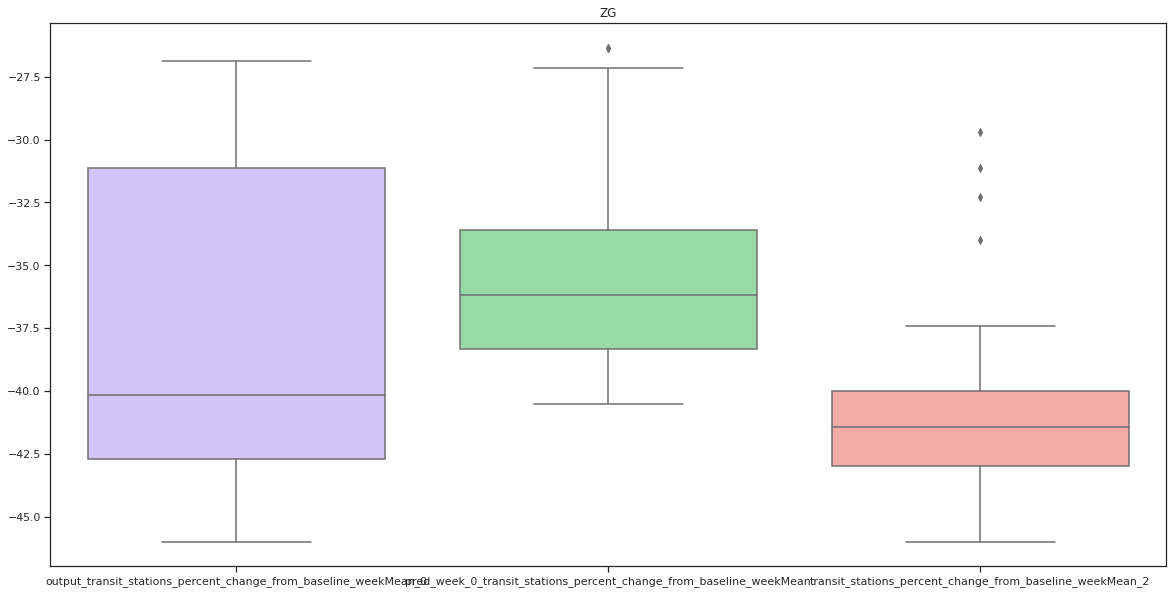

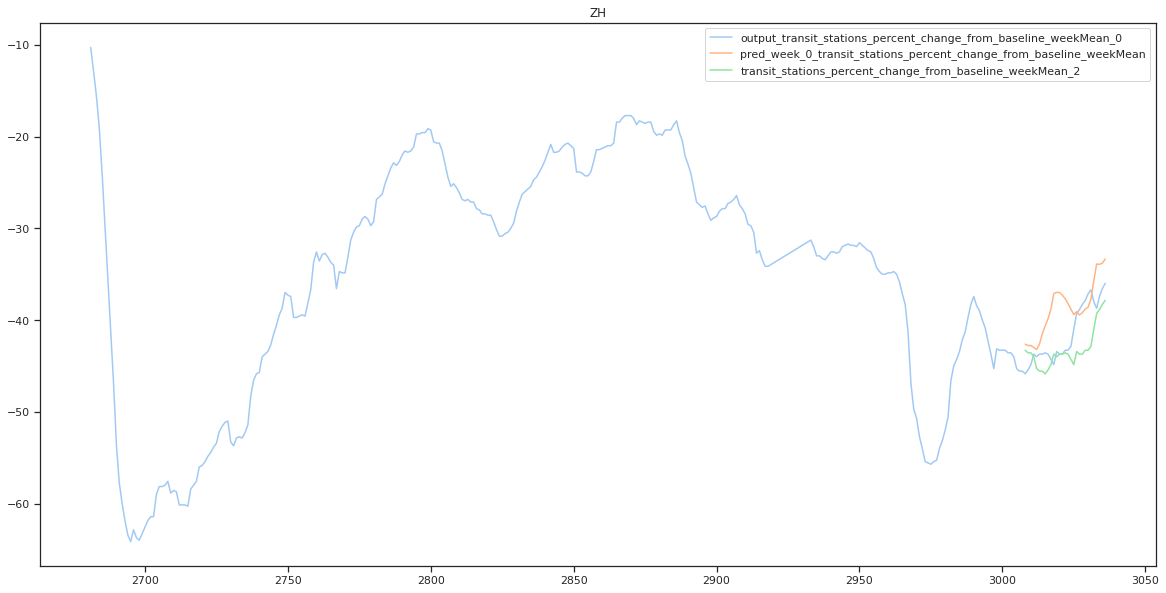

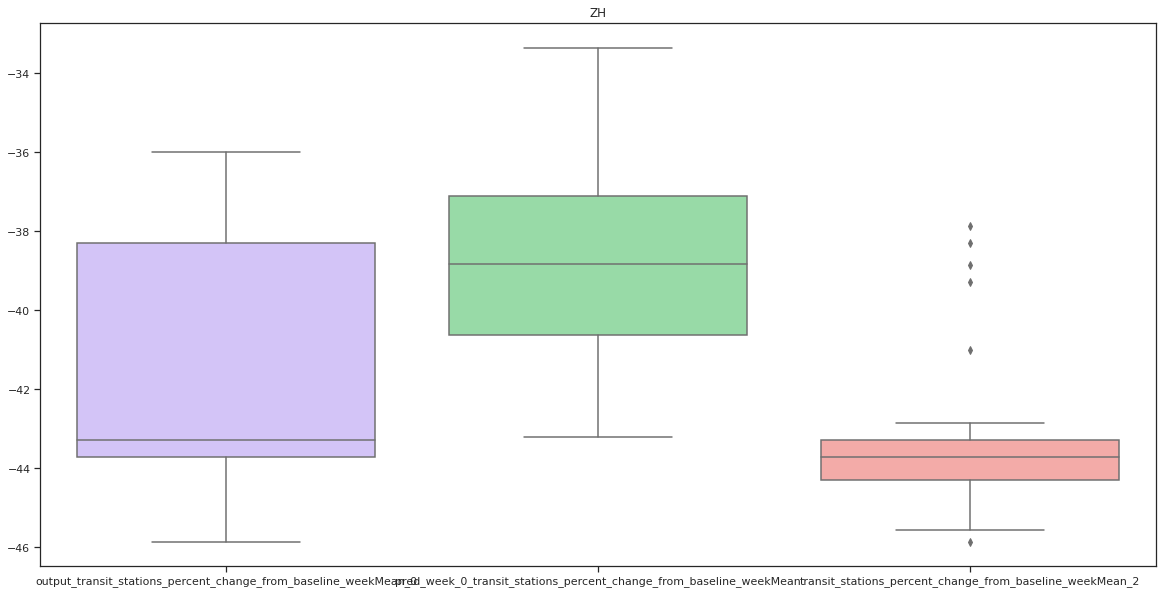

In [11]:
for cantonId in cantonKeys:
    category = regressors[identifier][1]
    dfForPlot = regressors[identifier][2] 

    d = dfForPlot[dfForPlot['cantonId']==cantonId]
    d = d.drop(['cantonId'], axis=1)
    d.plot(kind='line',figsize=(20,10), title=cantonId)
    plt.show()

    d = d[d[category+"_"+str(numberOfInputWeeks-1)].notna()]


    sns.set_theme(style="ticks", palette="pastel",rc={"figure.figsize":(20, 10)})
    sns.boxplot(palette=["m", "g", 'r'], data=d).set(title=cantonId)
    plt.show()

In [ ]:
'''
start = time.time()

featuresSelection = train_features.columns
label = 'testPositvity'

display("---Ridge---"+label+"---")
for alpha in [1,10,100,1000]:
    reg = linear_model.Ridge(alpha=alpha)
    display(reg)
    reg.fit(pip.fit_transform(train_features[featuresSelection].values), train_labels[[label]])
    predictions_valid1 = reg.predict(pip.fit_transform(validation1_features[featuresSelection].values))
    predictions_valid2 = reg.predict(pip.fit_transform(validation2_features[featuresSelection].values))
    rmse1 = np.sqrt(mean_squared_error(predictions_valid1, validation1_labels[[label]]))
    rmse2 = np.sqrt(mean_squared_error(predictions_valid2, validation2_labels[[label]]))
    baseline_rmse1 = np.sqrt(mean_squared_error(validation1_features[["baseline_"+label]],validation1_labels[[label]]))
    baseline_rmse2 = np.sqrt(mean_squared_error(validation2_features[["baseline_"+label]],validation2_labels[[label]]))
    display("Baseline RMSE validation set 1: "+str(baseline_rmse1))
    display("Model RMSE validation set 1: "+str(rmse1))
    display("Baseline RMSE validation set 2: "+str(baseline_rmse2))
    display("Model RMSE validation set 2: "+str(rmse2))
    display(pd.DataFrame(reg.coef_.transpose(), index=featuresSelection, columns=['coefficients']).sort_values(['coefficients'], ascending=False))   
    
display("----------End of evaluating (%s)----------" % (time.time() - start))
'''

In [ ]:
    
'''
cantonId = 'ZH'
pastOutput = pd.read_csv("data/outputs/"+cantonId+".csv")


predDf = pd.DataFrame()
for col in pastOutput.columns:
    p = predictors[col].predict(pip.fit_transform(pd.read_csv("data/newest/"+cantonId+".csv")))[0]
    temp = pd.DataFrame([p for i in range(7)], columns=[col+"_predictions"])
    predDf = pd.concat([predDf,temp], axis=1)
df = pastOutput.append(predDf, ignore_index=True)
for col in pastOutput.columns:
    df[[col]] = df[[col]].rolling(window=7).mean()
    df[[col,col+"_predictions"]].plot(kind='line', y=[col,col+"_predictions"], figsize=(20,10), xlabel='days', ylabel=col)
    plt.show()
'''
    